In [ ]:
# Install packages only in a fresh session
if(!("keras" %in% rownames(installed.packages()))){
    install.packages("tm")
    install.packages("pdp")
    install.packages("iml")
    install.packages("signs")
    install.packages("keras")
    install.packages("ggallin")
    install.packages("viridis")
    install.packages("ggrepel")
    install.packages("rugarch")
    install.packages("ggthemes")
    install.packages("ggridges")
    install.packages("patchwork")
    install.packages("tidyverse")
    install.packages("SnowballC")
    install.packages("data.table")
    install.packages("treemapify")
    install.packages("ggcorrplot")
    install.packages("SentimentAnalysis")
}

In [ ]:
library(tm)
library(pdp)
library(iml)
library(signs)
library(keras)
library(scales)
library(ggallin)
library(viridis)
library(ggrepel)
library(ggthemes)
library(ggridges)
library(patchwork)
library(lubridate)
library(tidyverse)
library(data.table)
library(treemapify)
library(ggcorrplot)
library(SentimentAnalysis)

In [ ]:
# Setup

# Volatility window in days
volatility_window <- 10

# Sentiment window (backwards) in days
sentiment_window <- 30

# Disable scientific notation of numbers
options(scipen = 999)

# Plot output size
options(repr.plot.width = 15, repr.plot.height = 12)

# Set custom theme as default
theme_crypto <- function() {
  theme_minimal() %+replace%
    theme(axis.text = element_text(size = 15),
          plot.title = element_text(size = 25, margin = margin(10, 0, 15, 0)),
          axis.title = element_text(size = 15),
          strip.text = element_text(size = 15),
          legend.text = element_text(size = 15),
          legend.title = element_text(size = 15),
          legend.key.size = unit(3, "line"),
          legend.position = "none")
}

theme_set(theme_crypto())

# Custom plot scales for millions and billions of dollars
m_scale <- function(x){ 
    number_format(accuracy = 1,
                  scale = 1 / 1e6,
                  prefix = "$",
                  suffix = "M",
                  big.mark = ",")(x)
}

bn_scale <- function(x){ 
    number_format(accuracy = 0.1,
                  scale = 1 / 1e9,
                  prefix = "$",
                  suffix = "bn",
                  big.mark = ",")(x)
}

# Adding leads of returns to data frame for volatility calculation
add_leads <- function(df, lead_n){
  col_name <- paste0("return_", lead_n)
  
  df %>% 
    mutate(!!col_name := lead(return, lead_n))
}

# Adding lags of sentiment
add_lags <- function(df, lag_n){
  col_name <- paste0("sentiment_mean_", lag_n)
  
  df %>% 
    mutate(!!col_name := lag(sentiment_mean, lag_n))
}

In [ ]:
# Functions for mapping
min_max_normalize <- function(x, original) {
  (x - min(original, na.rm = TRUE)) /
    (max(original, na.rm = TRUE) -
       min(original, na.rm = TRUE))
}

min_max_denormalize <- function(x, original) {
  rescale(x, to = c(min(original), max(original)))
}

normalize_multiple <- function(feature, .x){
  feature %>%
      mutate(!!colnames(.)[1] := 
              min_max_normalize(test_nonscaled %>% pull(.x),
                                train_scaling_columns %>% pull(.x)))
}

In [ ]:
list.files(pattern = "*.csv", 
                              full.names = TRUE)

[1] "./analyzed_sentiment.csv"     "./BinanceCoin_gru.csv"       
 [3] "./BinanceCoin_runs1layer.csv" "./Bitcoin_gru.csv"           
 [5] "./btc_runs1layer.csv"         "./coin_BinanceCoin.csv"      
 [7] "./coin_Bitcoin.csv"           "./coin_Ethereum.csv"         
 [9] "./coin_Iota.csv"              "./coin_XRP.csv"              
[11] "./eth_runs1layer.csv"         "./Ethereum_gru.csv"          
[13] "./IOTA_gru.csv"               "./IOTA_runs1layer.csv"       
[15] "./XRP_runs1layer.csv"

In [ ]:
crypto_data <- map(list.files(pattern = "coin_", 
                              full.names = TRUE),
                   ~read.csv(.x)) %>% 
    reduce(bind_rows) %>%
    mutate(Date = as_date(ymd_hms(Date)))

In [ ]:
# Daily returns
crypto_returns <- crypto_data %>%
  arrange(Date) %>% 
  group_by(Name) %>% 
  mutate(return = Close / lag(Close) - 1)

Warning message:
“Removed 17 row(s) containing missing values (geom_path).”


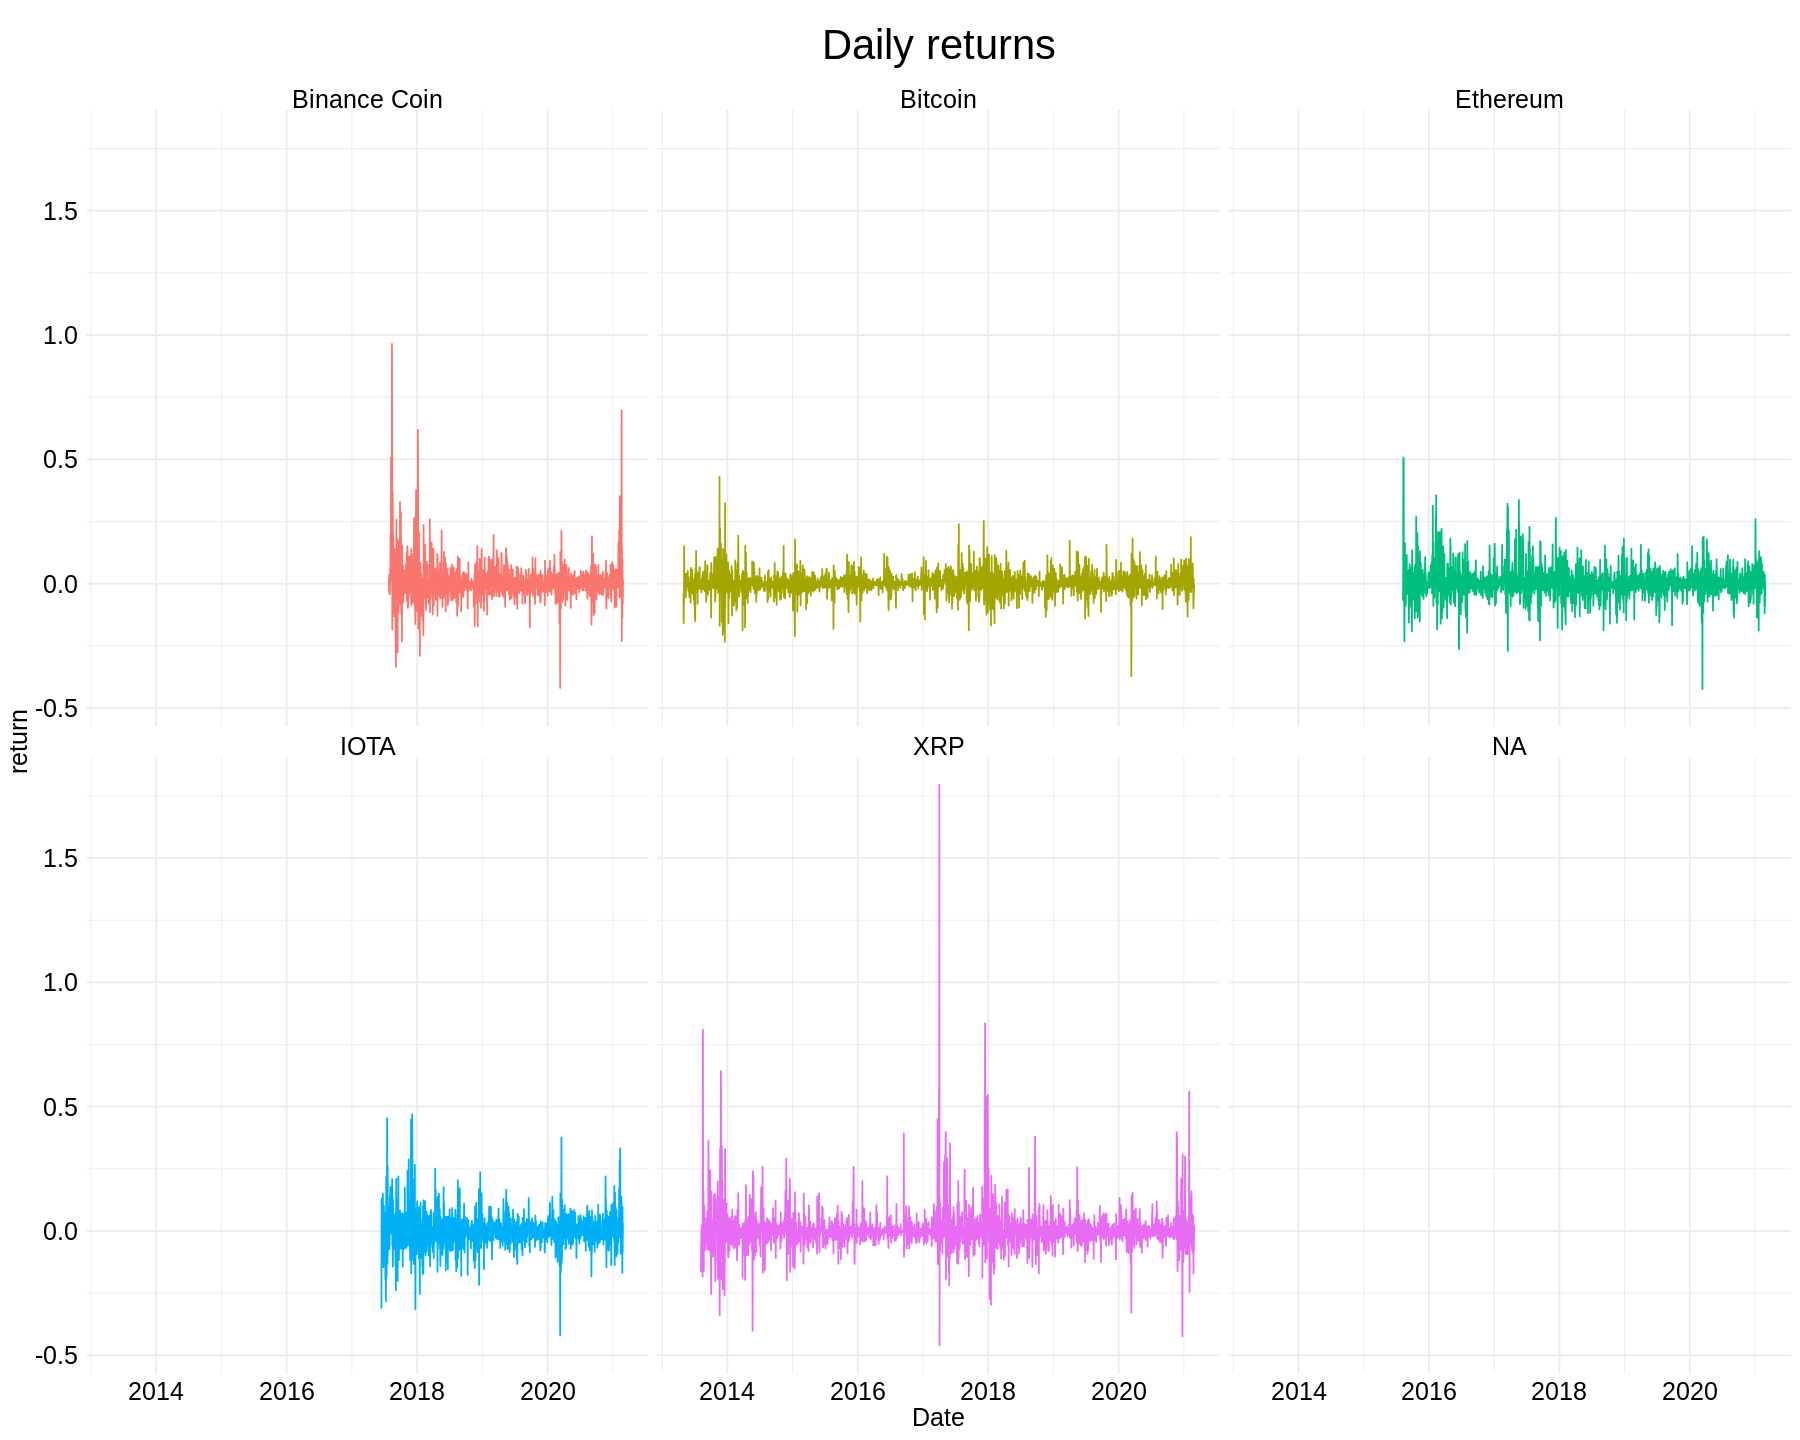

In [ ]:
crypto_returns %>%
  ggplot(aes(Date, return, color = Name)) +
  geom_line() +
  facet_wrap(~Name) +
  labs(title = "Daily returns")

In [ ]:
# Most volatile coins over the whole time period
crypto_returns %>% 
  group_by(Name) %>%
  summarise(volatility = sd(return, na.rm = TRUE)) %>%
  arrange(volatility)

Name,volatility
<chr>,<dbl>
Bitcoin,0.04249571
Ethereum,0.06291150
IOTA,0.07231412
Binance Coin,0.07994548
XRP,0.08071847
NA,NA


In [ ]:
# Calculate average future 10-day volatility
crypto_volatilities <- crypto_returns %>% 
    pull(Name) %>% 
    unique() %>% 
    map(~map(1:volatility_window,
             ~crypto_returns %>% 
                 filter(Name == .y) %>% 
                 add_leads(.x),
             .y = .x) %>% 
            reduce(inner_join)) %>% 
    reduce(bind_rows) %>% 
    pivot_longer(starts_with("return_")) %>% 
    group_by_at(vars(-name, -starts_with("return_"), -value)) %>% 
    summarise(volatility_10_day = sd(value, na.rm = TRUE)) %>%
    ungroup() %>% 
    suppressMessages()

In [ ]:
crypto_volatilities %>% head()

X,run_dir,metric_loss,metric_mse,metric_val_loss,metric_val_mse,flag_units1,flag_activation1,flag_recurrent_activation1,flag_recurrent_dropout1,⋯,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,return,volatility_10_day
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<int>,⋯,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,BNB,2017-07-26,0.10901300,0.09926550,0.10589300,0.10513800,200395,10513800,NA,0.06973561
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,BTC,2013-04-29,147.48800659,134.00000000,134.44400024,144.53999329,0,1603768864,NA,0.08314241
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,ETH,2015-08-08,2.79881001,0.71472502,2.79376006,0.75332499,674188,45486894,NA,0.25153936
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,MIOTA,2017-06-14,0.60619599,0.49574500,0.59234703,0.52891600,14194900,1470138039,NA,0.12637639
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,XRP,2013-08-05,0.00597984,0.00561266,0.00587478,0.00561266,0,43879157,NA,0.07445704
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,BNB,2017-07-27,0.10847900,0.10088800,0.10510800,0.10773700,344499,10773700,0.0247199,0.06975570


Warning message:
“Removed 10 row(s) containing missing values (geom_path).”


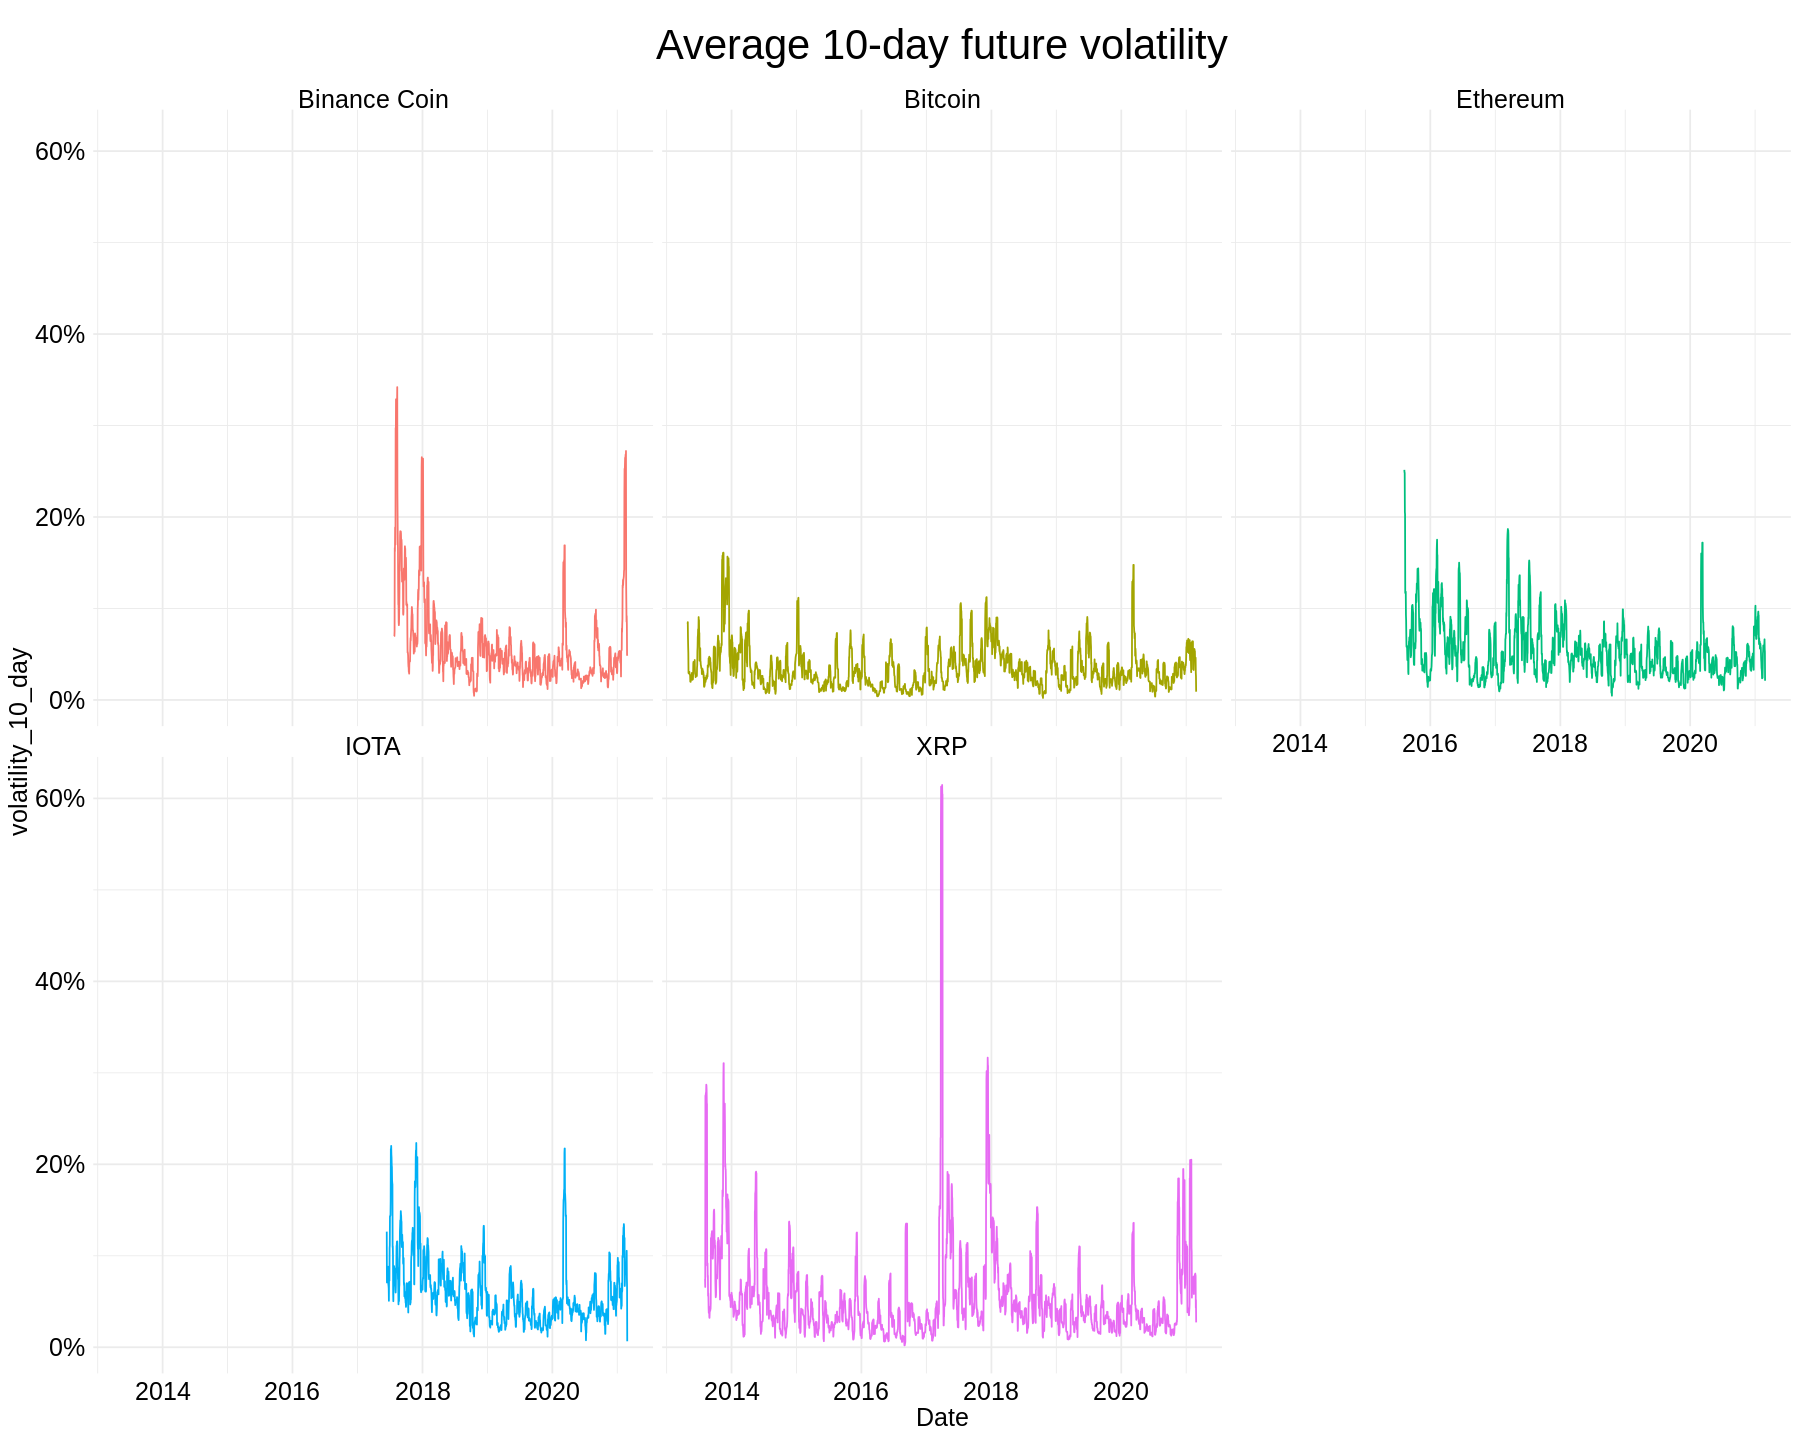

In [ ]:
crypto_volatilities %>%
  ggplot(aes(Date, volatility_10_day, color = Name)) +
  geom_line() +
  facet_wrap(~Name) +
  scale_y_continuous(label = scales::percent) +
  labs(title = "Average 10-day future volatility")

In [ ]:
# GARCH
# I extract coin information from the variable "crypto_volatilities"

GARCH_FUNCTION <- function(coin,n){
  
  #Returns from the given coin
  returns <-ts(crypto_volatilities[crypto_volatilities$Symbol==coin,"return"])
  returns <- na.omit(returns) 
  
  # Estimate the model specs. 
  # Should we tweak the ARMA parameters? I think (1.1) is the standard
  ug_spec <- rugarch::ugarchspec(mean.model = list(armaOrder = c(1, 1)))
  ugfit = rugarch::ugarchfit(spec=ug_spec, data=returns)
  
  # Forecast n days
  fc <-rugarch::ugarchforecast(ugfit, n.ahead = n)
  
  # Transform the GARCH output to average of the next 10(volatility_window) days
  ten_day_fc<-c()
  for (i in 1:(n-volatility_window)){
    
    ten_day_fc <-
      c(ten_day_fc, 
        mean(fc@forecast[["sigmaFor"]][(i + 1):(i + volatility_window)]))
  }
  return(ten_day_fc)
}

#Forecast output:

ETH_fc <- GARCH_FUNCTION("ETH",100)
BNB_fc <- GARCH_FUNCTION("BNB",100)
MIOTA_fc <- GARCH_FUNCTION("MIOTA",100)
XRP_fc <- GARCH_FUNCTION("XRP",100)

# BTC is commented since i forgot to load BTC prices to this session
BTC_fc <- GARCH_FUNCTION("BTC",100) 

#Test to see if it worked:
ETH_fc
length(ETH_fc) #Should be 90

[1] 0.06113277 0.06142084 0.06168952 0.06194022 0.06217419 0.06239262
 [7] 0.06259660 0.06278714 0.06296514 0.06313149 0.06328696 0.06343230
[13] 0.06356819 0.06369527 0.06381411 0.06392528 0.06402928 0.06412658
[19] 0.06421762 0.06430282 0.06438256 0.06445719 0.06452705 0.06459244
[25] 0.06465366 0.06471098 0.06476465 0.06481490 0.06486196 0.06490602
[31] 0.06494729 0.06498594 0.06502214 0.06505604 0.06508780 0.06511754
[37] 0.06514540 0.06517150 0.06519595 0.06521885 0.06524031 0.06526041
[43] 0.06527924 0.06529688 0.06531341 0.06532889 0.06534340 0.06535699
[49] 0.06536973 0.06538166 0.06539284 0.06540332 0.06541314 0.06542233
[55] 0.06543095 0.06543903 0.06544659 0.06545368 0.06546033 0.06546655
[61] 0.06547238 0.06547785 0.06548297 0.06548777 0.06549227 0.06549649
[67] 0.06550043 0.06550414 0.06550760 0.06551085 0.06551390 0.06551675
[73] 0.06551943 0.06552193 0.06552428 0.06552648 0.06552854 0.06553048
[79] 0.06553229 0.06553399 0.06553558 0.06553707 0.06553846 0.06553977
[85] 0.06554100 0.06554215 0.06554322 0.06554423 0.06554518 0.06554607

[1] 90

In [ ]:
crypto_data %>% head

,X,run_dir,metric_loss,metric_mse,metric_val_loss,metric_val_mse,flag_units1,flag_activation1,flag_recurrent_activation1,flag_recurrent_dropout1,⋯,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<int>,⋯,<int>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,runs/2021-04-15T23-17-32Z,0.0225,0.0225,0.0498,0.0498,32,tanh,hard_sigmoid,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,2,runs/2021-04-15T23-17-07Z,0.0234,0.0234,0.0464,0.0464,16,tanh,hard_sigmoid,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,3,runs/2021-04-15T23-16-40Z,0.0194,0.0194,0.0373,0.0373,8,tanh,hard_sigmoid,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,4,runs/2021-04-15T23-16-14Z,0.0224,0.0224,0.0328,0.0328,3,tanh,hard_sigmoid,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,5,runs/2021-04-15T23-15-26Z,0.0186,0.0186,0.0336,0.0336,32,tanh,hard_sigmoid,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,6,runs/2021-04-15T23-14-51Z,0.0277,0.0277,0.0285,0.0285,16,tanh,hard_sigmoid,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [ ]:
coindesk_news <- fread("https://raw.githubusercontent.com/Zmaznevegor/defi_uncertainty/main/data/news/coindesk.csv") %>% 
  mutate(date = as_date(ymd_hms(date))) %>% 
  as_tibble()

In [ ]:
# coindesk_news_dtm <- coindesk_news %>%
#   pull(text) %>% 
#   VectorSource() %>% 
#   Corpus() %>% 
#   DocumentTermMatrix(control = list(removePunctuation = TRUE,
#                                     stopwords = TRUE,
#                                     removeNumbers = TRUE,
#                                     setmming = TRUE,
#                                     tolower = TRUE,
#                                     wordLengths = c(5, 20)))

In [ ]:
# analyzed_sentiment <- coindesk_news %>% 
#   mutate(SentimentLM = analyzeSentiment(
#     coindesk_news_dtm, 
#     removeStopwords = TRUE, 
#     stemming = TRUE,
#     rules = list("SentimentLM" = list(ruleSentiment, 
#                                       loadDictionaryLM()))) %>% 
#       pull(SentimentLM))

In [ ]:
analyzed_sentiment <- read.csv("analyzed_sentiment.csv") %>%
    mutate(date = as_date(date))

In [ ]:
analyzed_sentiment %>% head

X date      
1 1 2021-03-19
2 2 2021-03-19
3 3 2021-03-19
4 4 2021-03-19
5 5 2021-03-19
6 6 2021-03-19
  text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [ ]:
analyzed_sentiment_to_model_temp <- analyzed_sentiment %>% 
  filter(SentimentLM != 0) %>% 
  mutate(lower_text = tolower(text),
         mentioned_coin = case_when(
           str_detect(lower_text, "binance coin|bnb") ~ "Binance Coin",
           str_detect(lower_text, "bitcoin|btc") ~ "Bitcoin",
           str_detect(lower_text, "ethereum|eth") ~ "Ethereum",
           str_detect(lower_text, "iota|miota") ~ "IOTA",
           str_detect(lower_text, "ripple|xrp") ~ "XRP",
           TRUE ~ "Other")) %>% 
  filter(!str_detect(lower_text, "sponsored")) %>%
  select(everything(), -text, -lower_text, text, lower_text)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
“Computation failed in `stat_smooth()`:
x has insufficient unique values to support 10 knots: reduce k.”


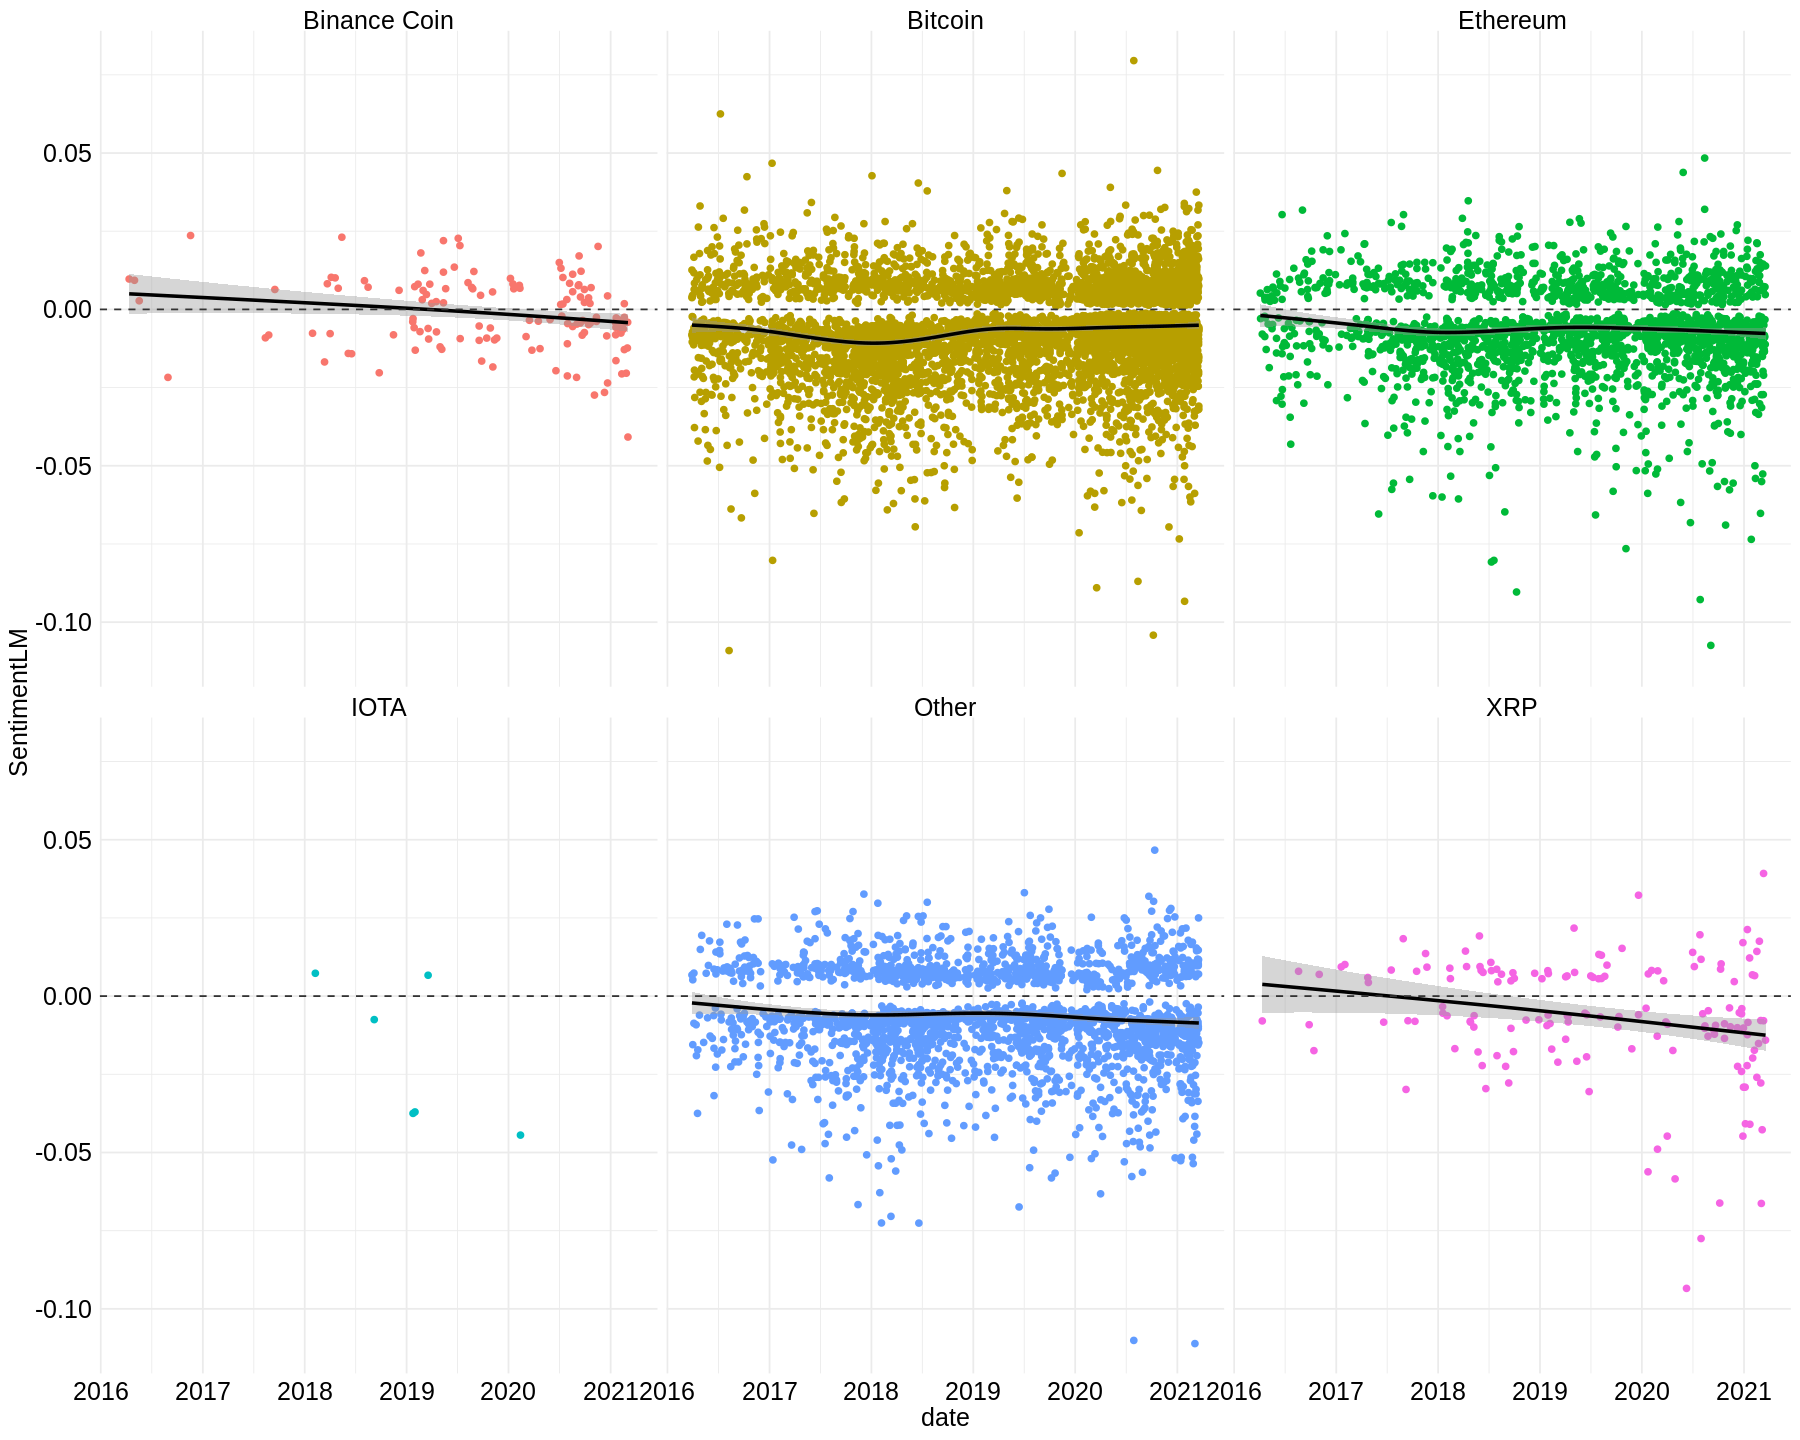

In [ ]:
analyzed_sentiment_to_model_temp %>% 
  ggplot(aes(date, SentimentLM, color = mentioned_coin)) +
  geom_point() +
  geom_smooth(color = "black") +
  geom_hline(yintercept = 0, color = "gray20",  linetype = "dashed") +
  facet_wrap(~mentioned_coin) +
  scale_x_date(breaks = seq.Date(ymd("2016-01-01"),
                                 ymd("2021-01-01"),
                                 "1 year"),
               labels = 2016:2021) +
  theme(legend.position = "none")

In [ ]:
analyzed_sentiment_to_model <- analyzed_sentiment_to_model_temp %>%
    ungroup() %>%
    group_by(date, mentioned_coin) %>%
    summarise(sentiment_mean = mean(SentimentLM, na.rm = TRUE)) %>%
    ungroup() %>%
    left_join(expand.grid(coin = na.omit(unique(crypto_data$Name)),
            date = seq.Date(min(analyzed_sentiment$date), 
                            max(analyzed_sentiment$date), 
                            "1 day")))

`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.

Joining, by = "date"



In [ ]:
analyzed_sentiment_to_model_lags <- analyzed_sentiment_to_model %>% 
    pull(mentioned_coin) %>% 
    unique() %>% 
    map(~map(1:sentiment_window,
             ~analyzed_sentiment_to_model %>% 
                 filter(coin == .y,
                        mentioned_coin == .y) %>% 
                        arrange(date) %>%
                        add_lags(.x),
             .y = .x) %>% 
            reduce(inner_join)) %>% 
    reduce(bind_rows) %>% 
    pivot_longer(starts_with("sentiment_mean_")) %>% 
    group_by_at(vars(-name, -starts_with("sentiment_mean_"), -value)) %>% 
    summarise(sentiment_past = mean(value, na.rm = TRUE)) %>%
    ungroup() %>% 
    na.omit() %>%
    suppressMessages()

In [ ]:
analyzed_sentiment_to_model_lags$sentiment_past %>% summary

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.018689 -0.008488 -0.006493 -0.006399 -0.004685  0.009709 

In [ ]:
crypto_volatilities %>% head

X,run_dir,metric_loss,metric_mse,metric_val_loss,metric_val_mse,flag_units1,flag_activation1,flag_recurrent_activation1,flag_recurrent_dropout1,⋯,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,return,volatility_10_day
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<int>,⋯,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,BNB,2017-07-26,0.10901300,0.09926550,0.10589300,0.10513800,200395,10513800,NA,0.06973561
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,BTC,2013-04-29,147.48800659,134.00000000,134.44400024,144.53999329,0,1603768864,NA,0.08314241
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,ETH,2015-08-08,2.79881001,0.71472502,2.79376006,0.75332499,674188,45486894,NA,0.25153936
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,MIOTA,2017-06-14,0.60619599,0.49574500,0.59234703,0.52891600,14194900,1470138039,NA,0.12637639
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,XRP,2013-08-05,0.00597984,0.00561266,0.00587478,0.00561266,0,43879157,NA,0.07445704
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,BNB,2017-07-27,0.10847900,0.10088800,0.10510800,0.10773700,344499,10773700,0.0247199,0.06975570


Warning message:
“Removed 5 row(s) containing missing values (geom_path).”


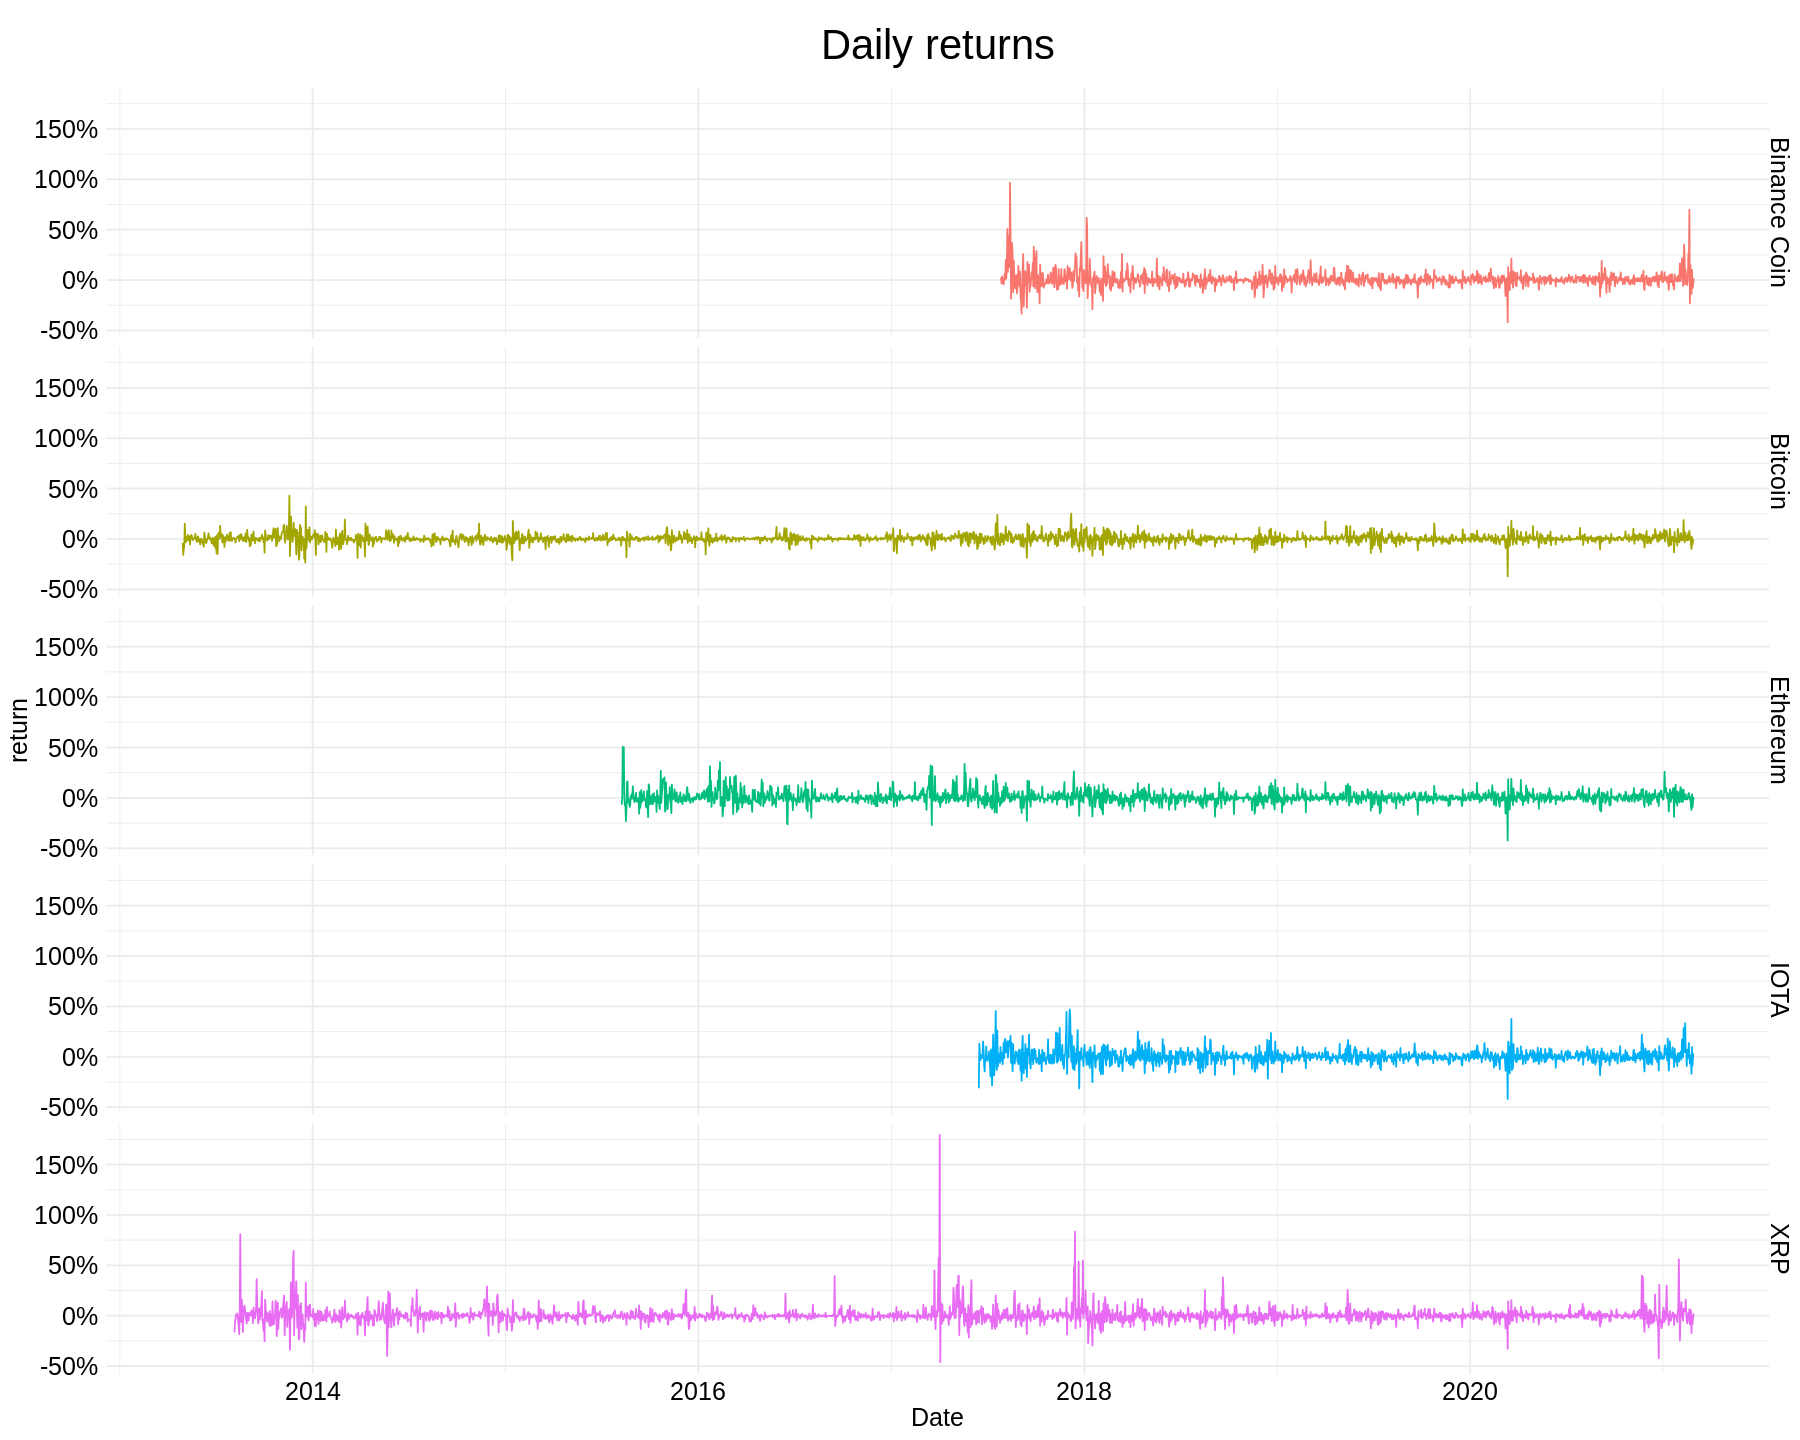

In [ ]:
#The same plot
crypto_volatilities %>%
  ggplot(aes(Date, return, color = Name)) +
  geom_line() +
  facet_grid(Name~.) +
  scale_y_continuous(label = scales::percent) +
  labs(title = "Daily returns")

Warning message:
“Removed 10 row(s) containing missing values (geom_path).”


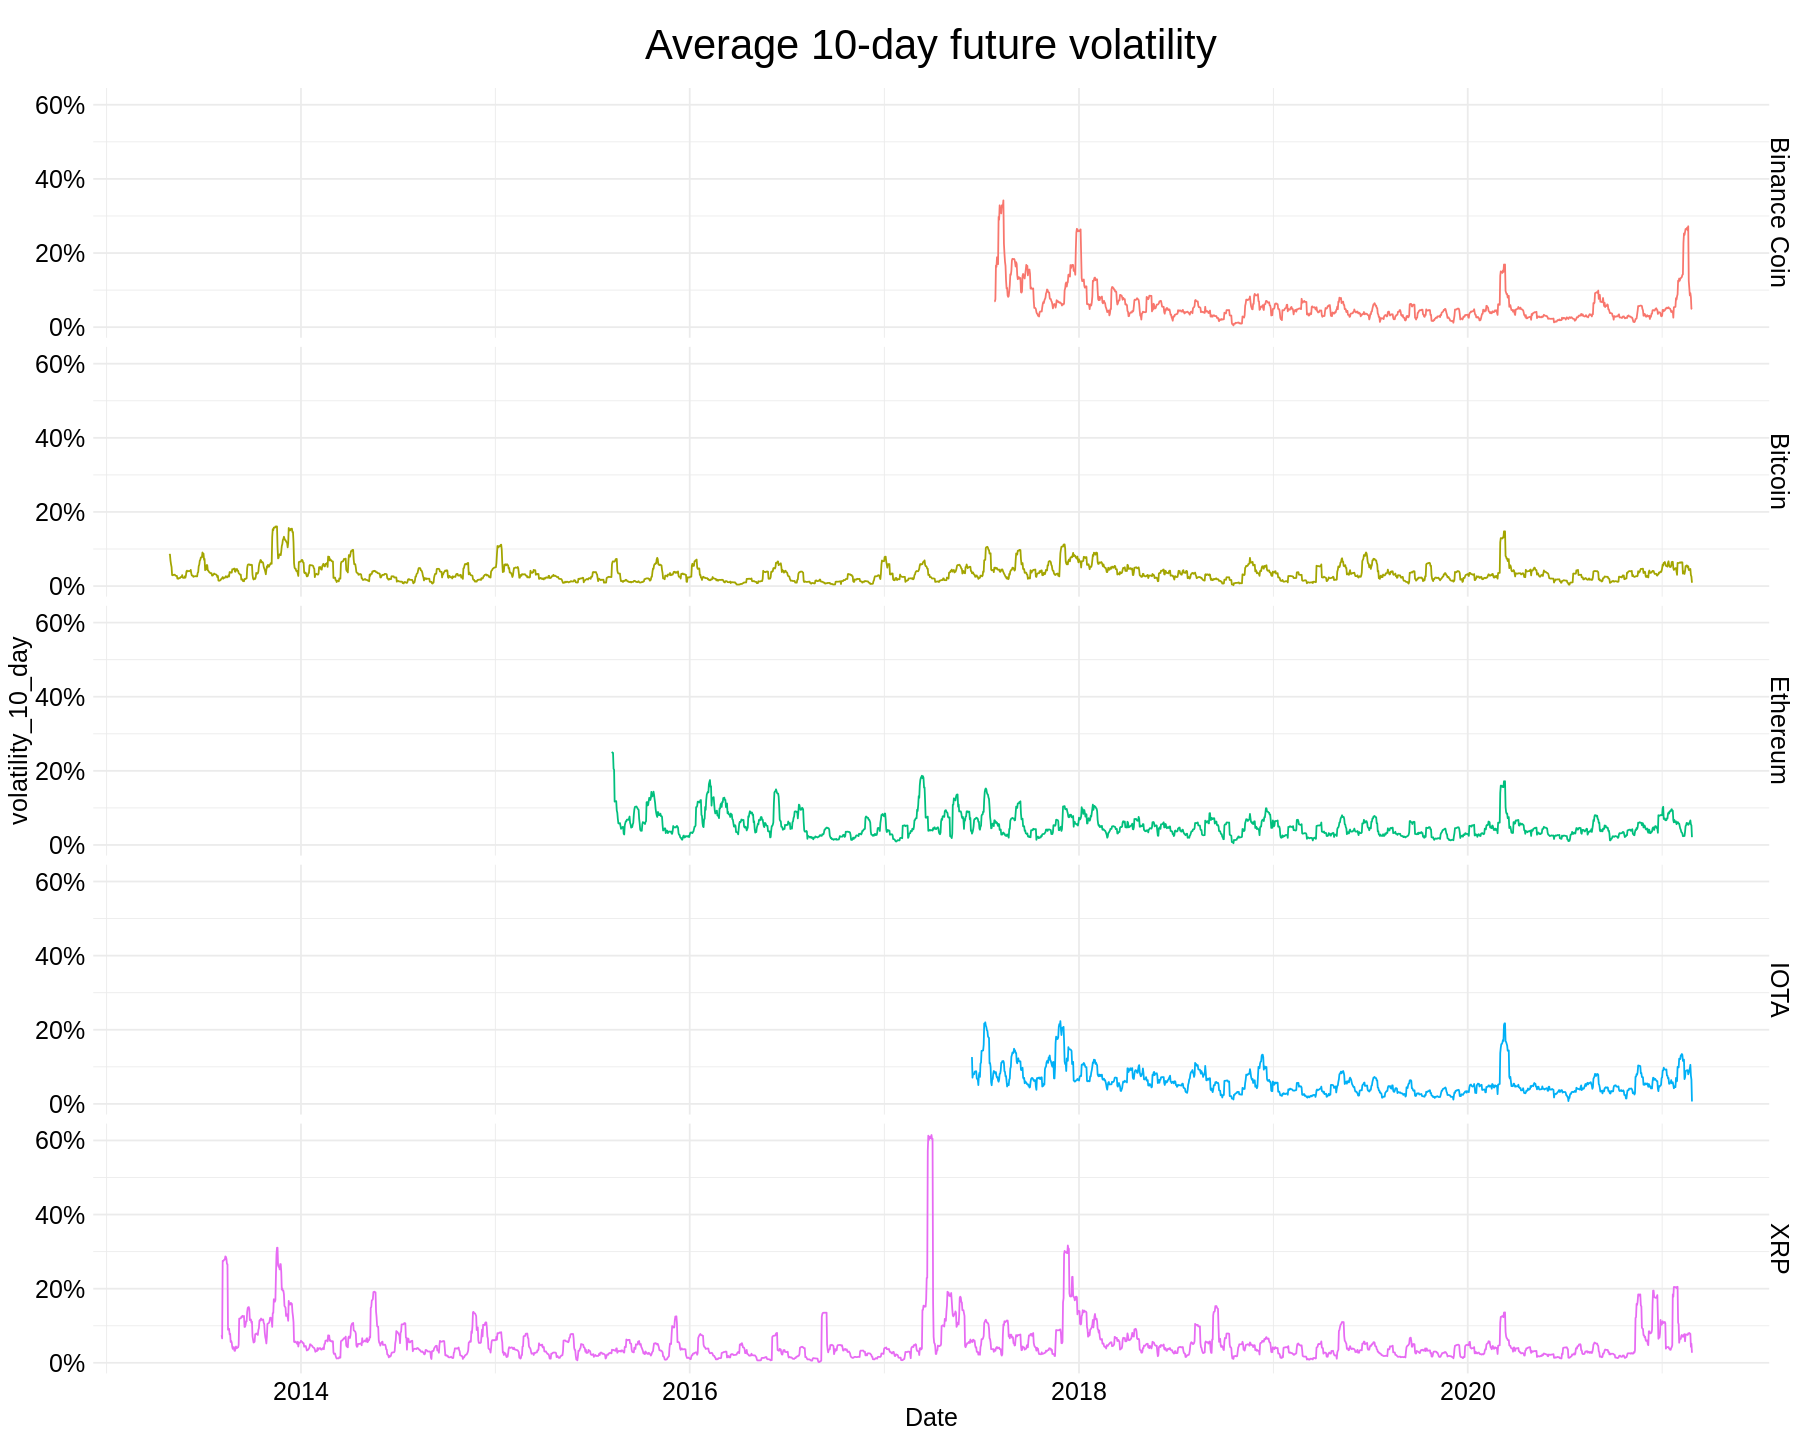

In [ ]:
#The same plot
crypto_volatilities %>%
  ggplot(aes(Date, volatility_10_day, color = Name)) +
  geom_line() +
  facet_grid(Name~.) +
  scale_y_continuous(label = scales::percent) +
  labs(title = "Average 10-day future volatility")

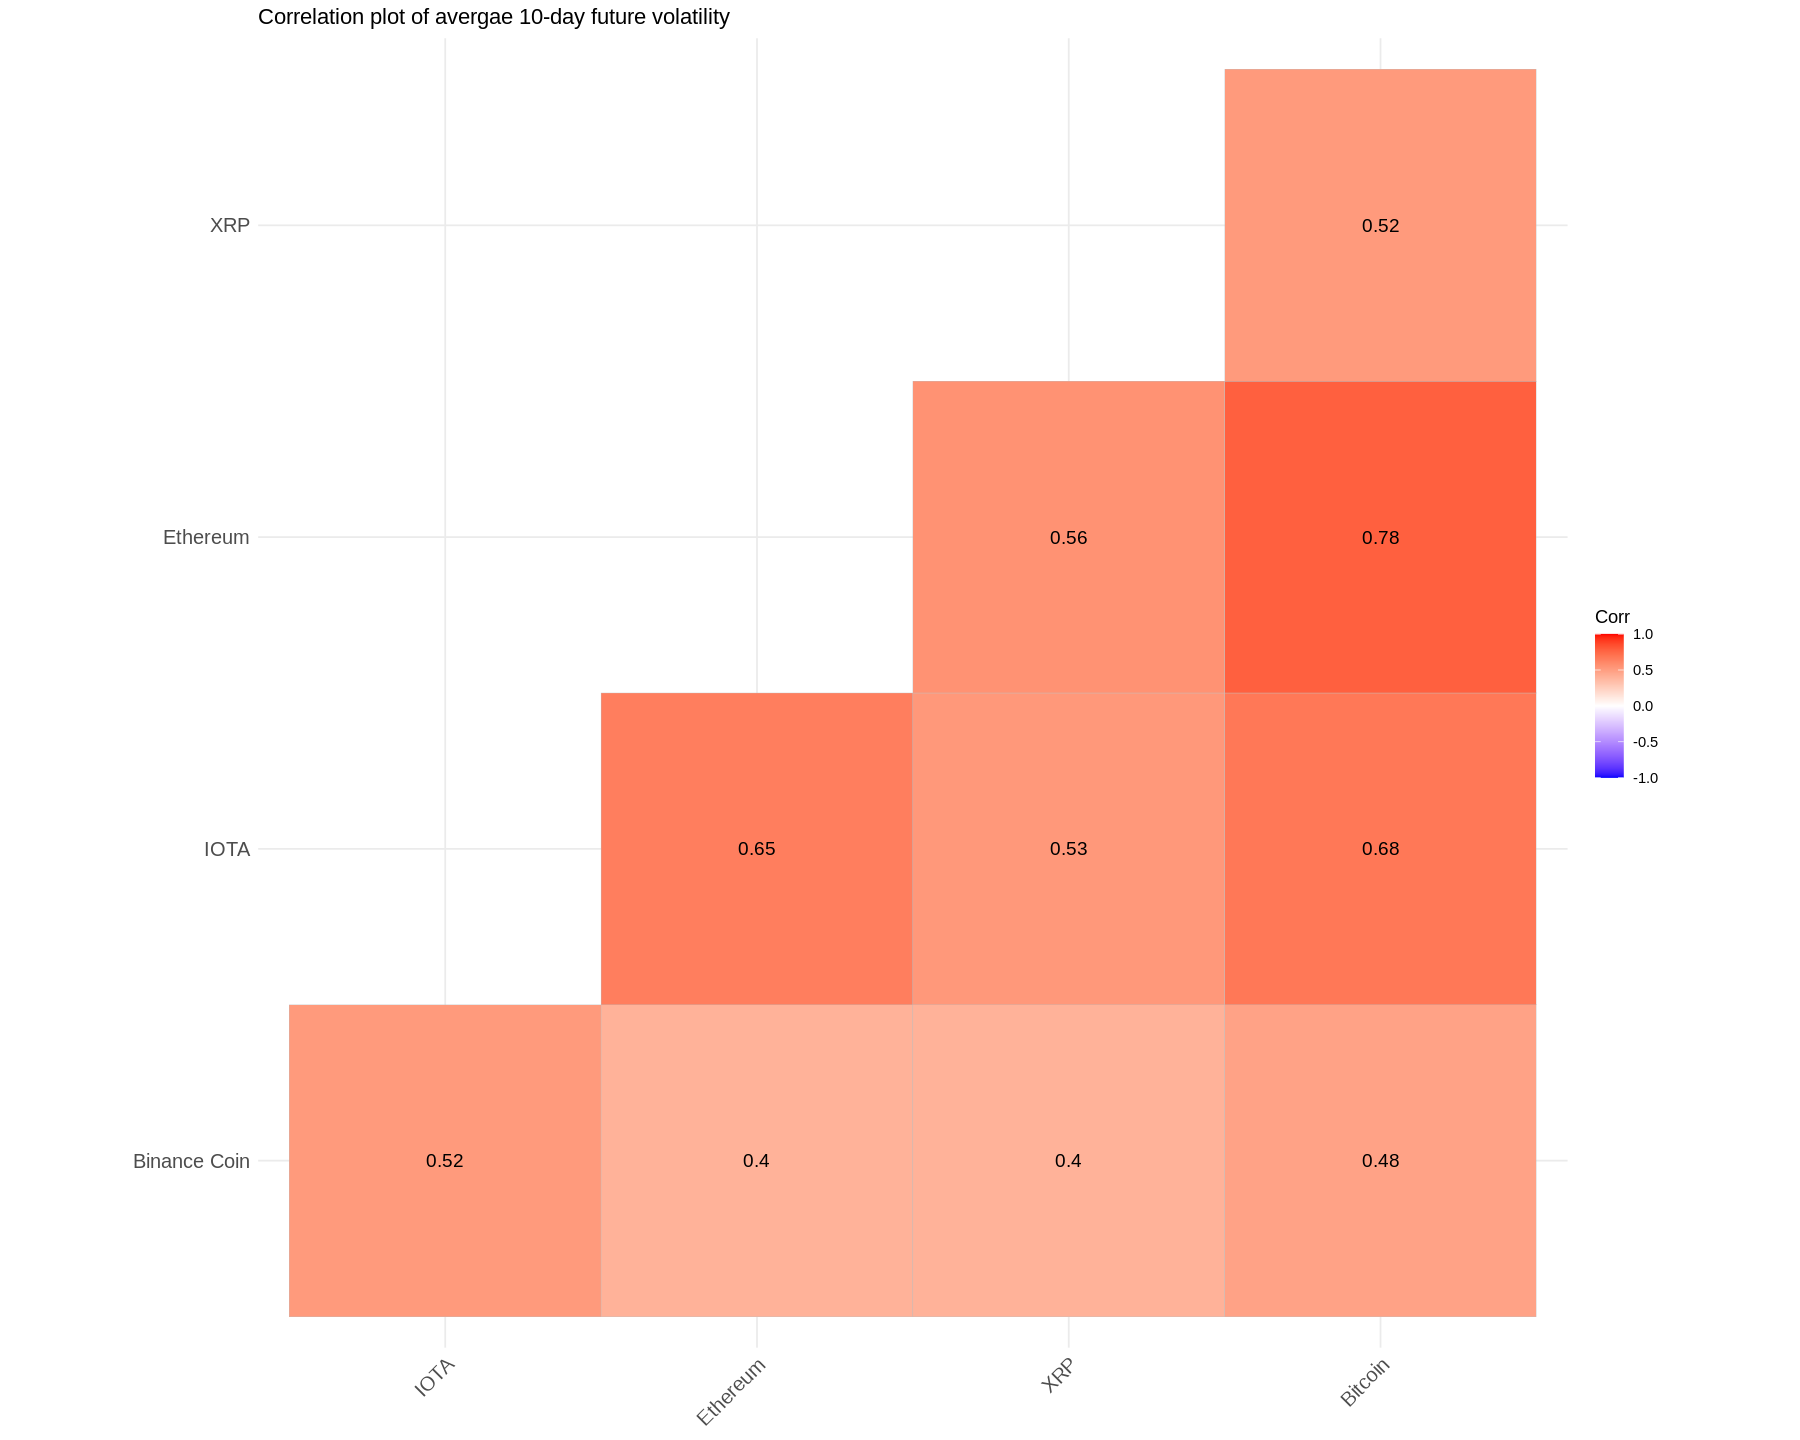

In [ ]:
#Correlation plot
crypto_volatilities%>%
  select(Name, Date, volatility_10_day)%>%
  filter(!Date<"2017-07-26")%>%
  pivot_wider(names_from = Name, values_from = volatility_10_day)%>%
  select(-Date)%>%
  cor(use = "pairwise.complete.obs")%>%
  ggcorrplot(type = "lower", lab = TRUE)+
  ggtitle("Correlation plot of avergae 10-day future volatility")

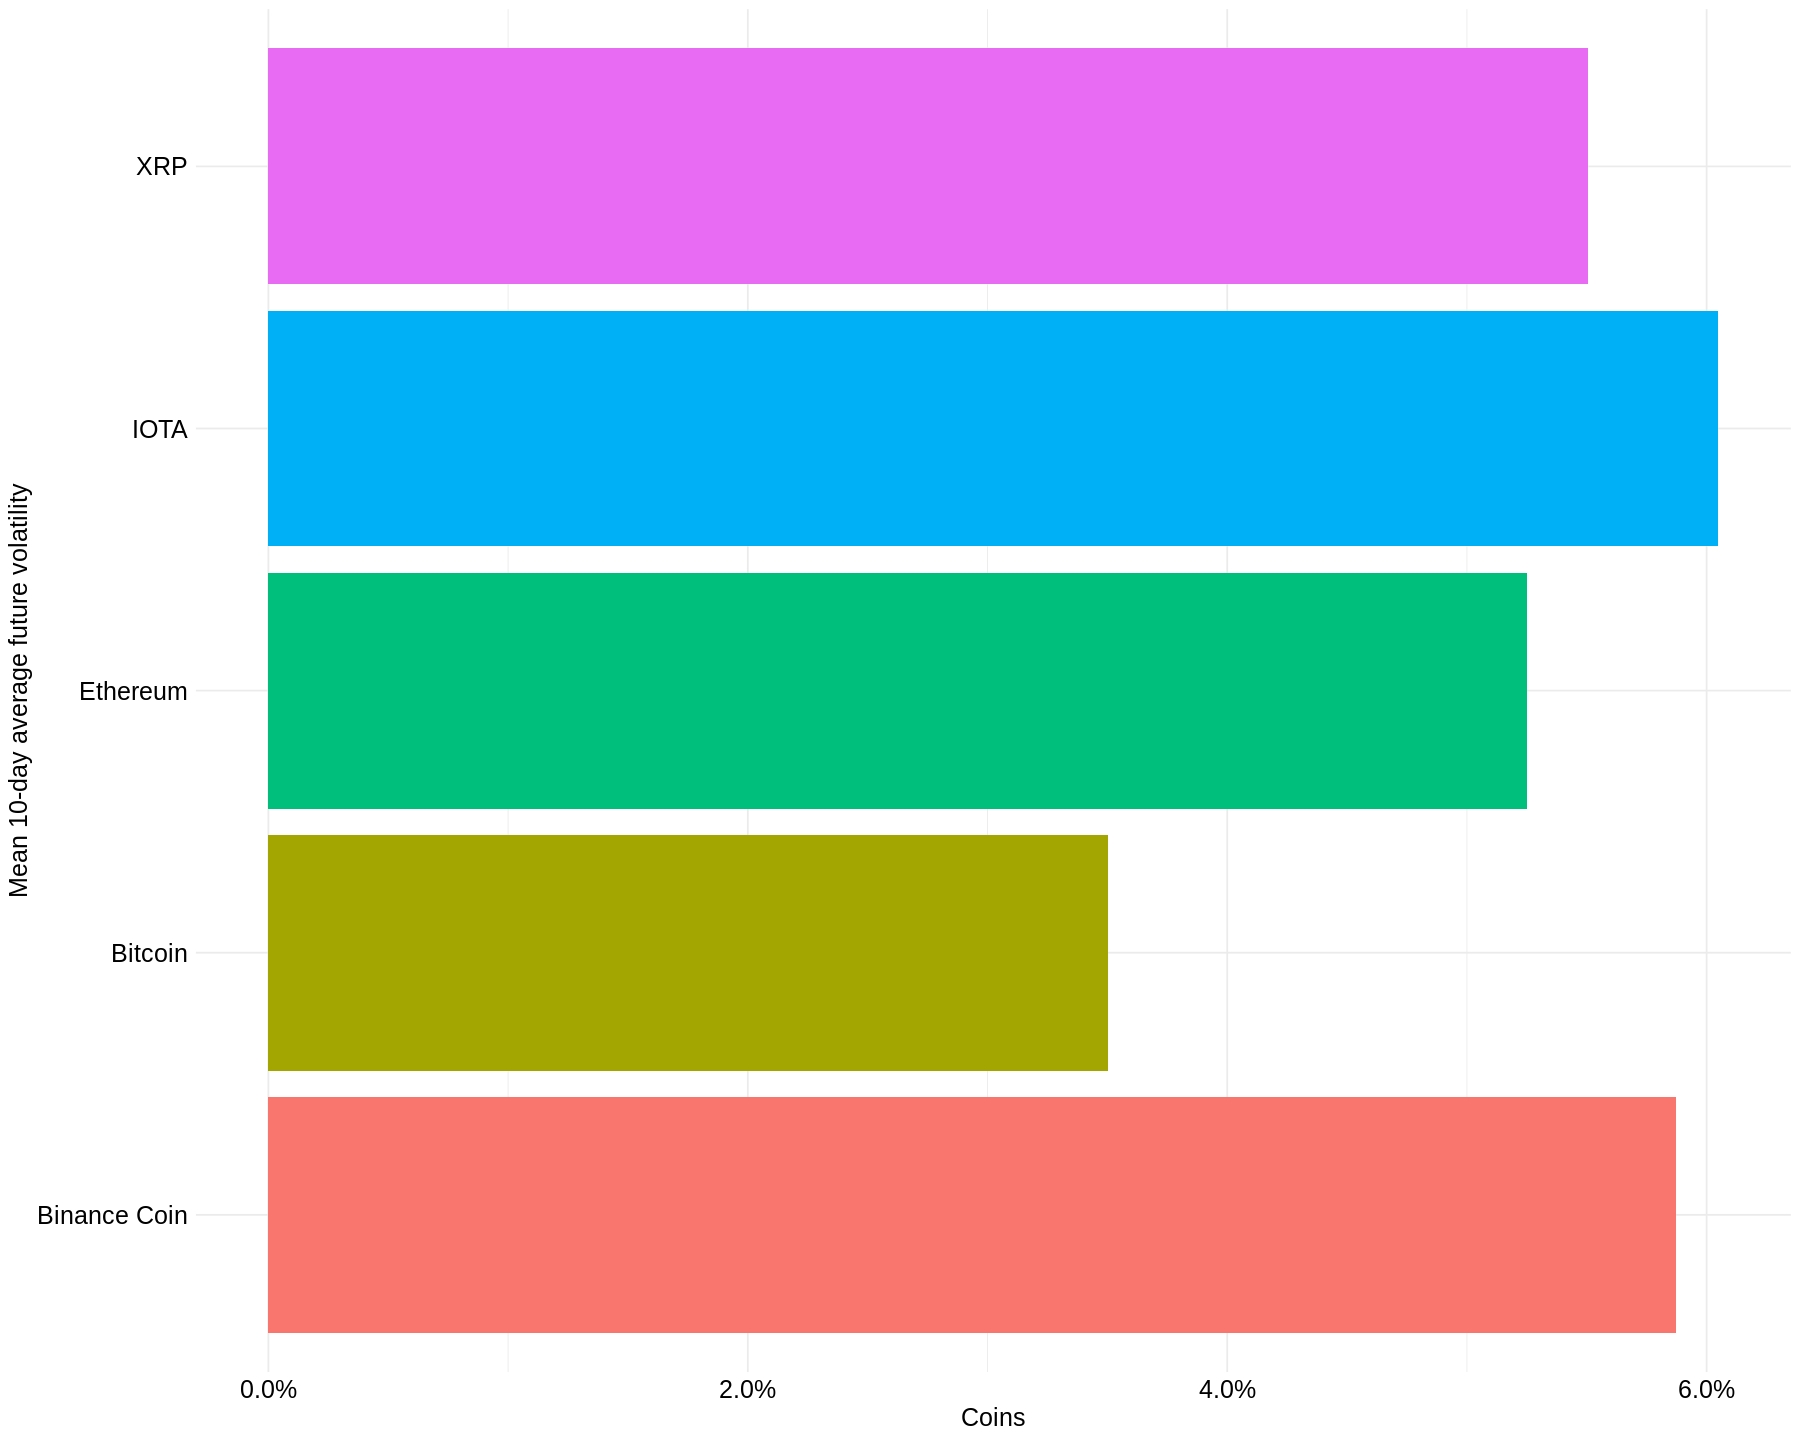

In [ ]:
#Mean 10-day average future volatility
crypto_volatilities%>%
  filter(!is.na(volatility_10_day))%>%
  group_by(Name)%>%
  summarize(mean_volaitility=mean(volatility_10_day))%>%
  ggplot(aes(x=mean_volaitility, y=Name, fill=Name))+
  geom_bar(stat="identity")+
  scale_x_continuous(label = scales::percent)+
  xlab("Coins")+
  ylab("Mean 10-day average future volatility")

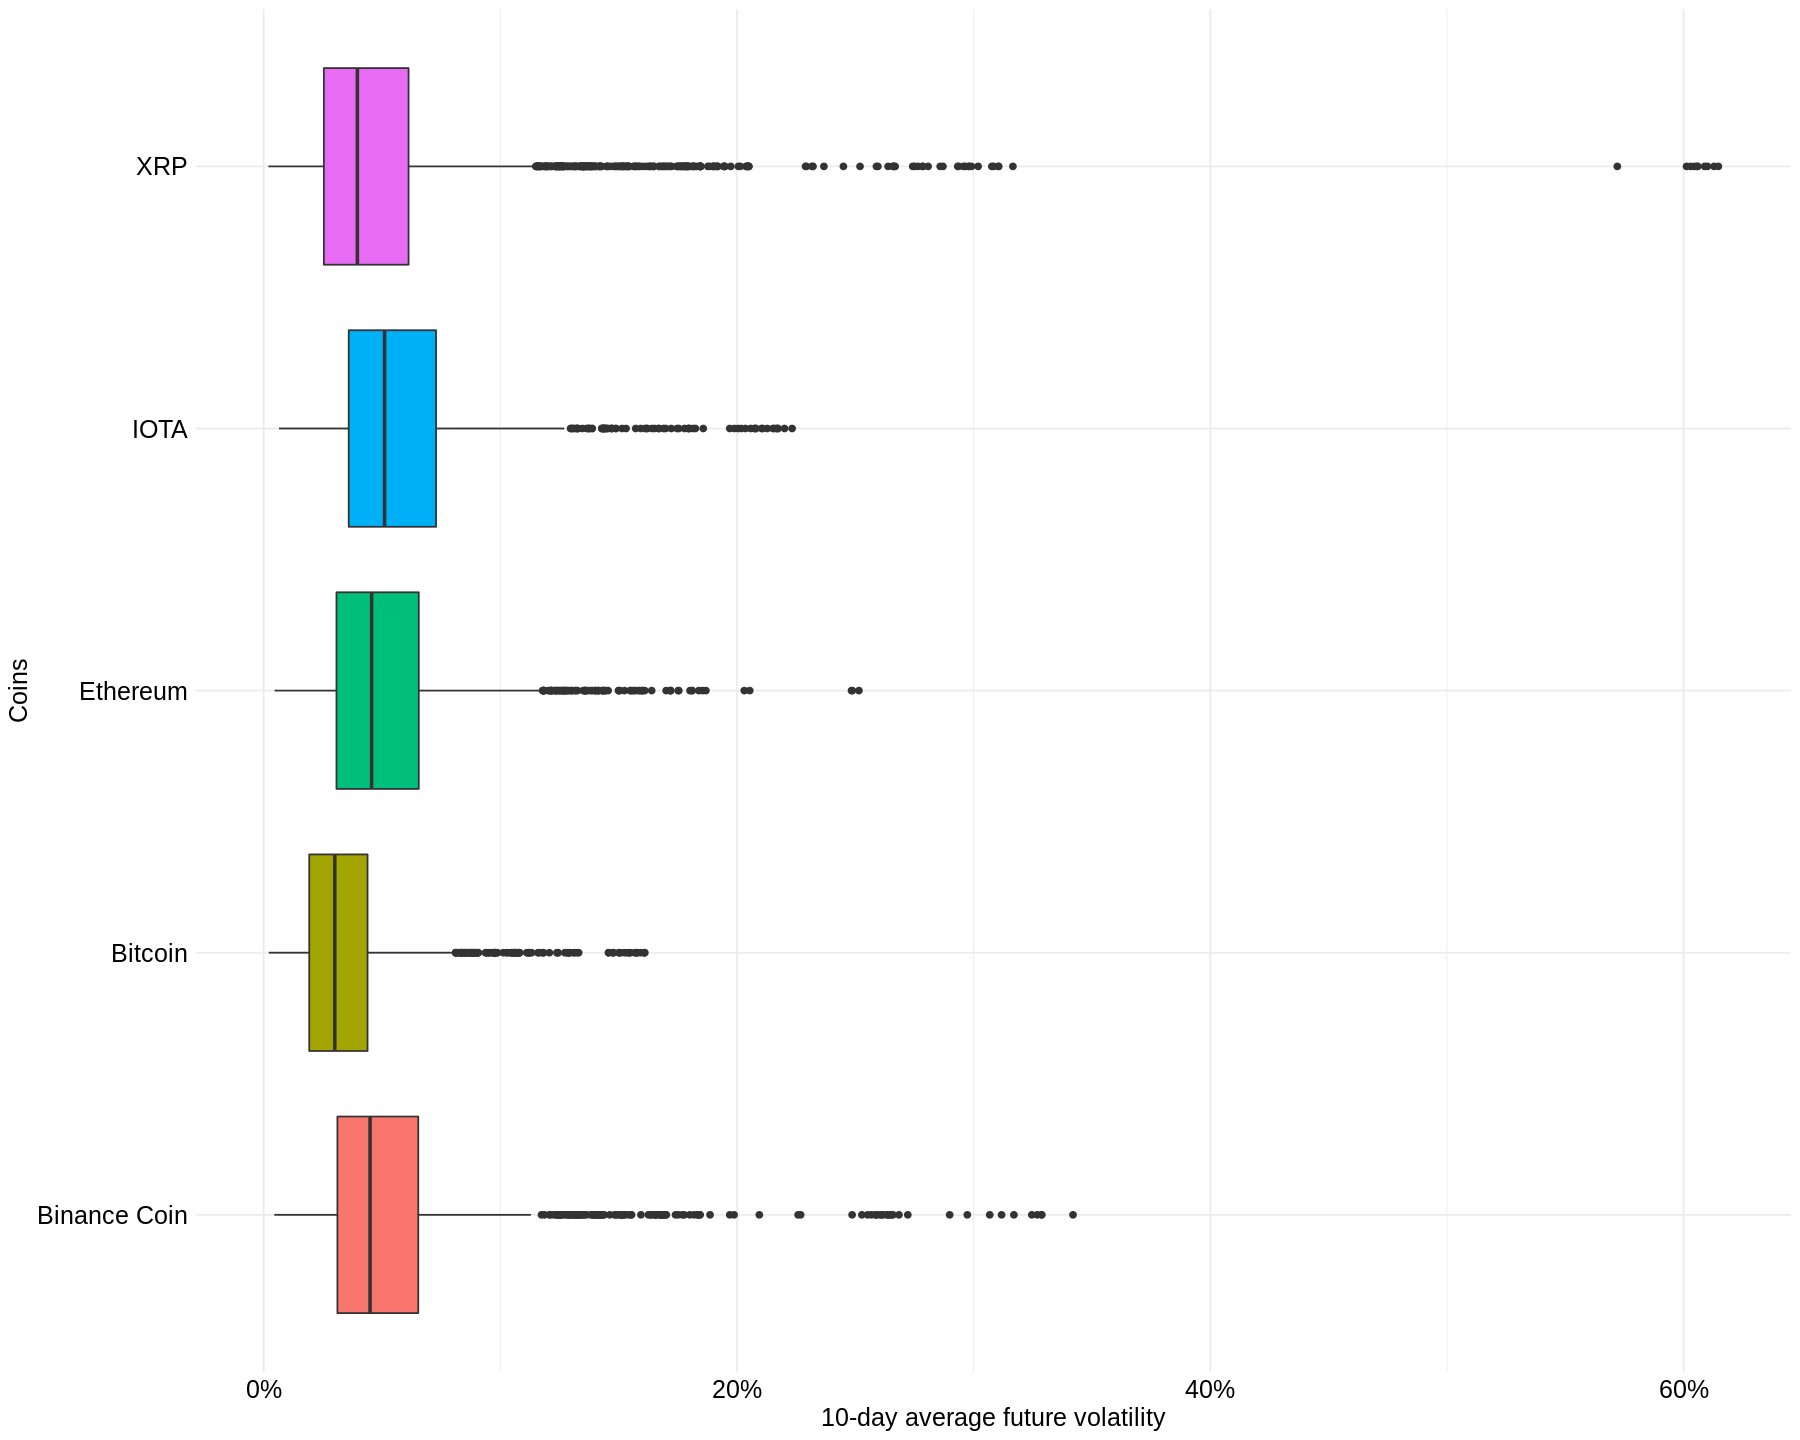

In [ ]:
#Box-plot
crypto_volatilities %>%
  filter(!is.na(volatility_10_day))%>%
  ggplot(aes(x=volatility_10_day, y=Name, fill= Name ))+
  geom_boxplot()+
  scale_x_continuous(label = scales::percent) +
  ylab("Coins")+
  xlab("10-day average future volatility")

In [ ]:
crypto_volatilities %>% head

X,run_dir,metric_loss,metric_mse,metric_val_loss,metric_val_mse,flag_units1,flag_activation1,flag_recurrent_activation1,flag_recurrent_dropout1,⋯,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,return,volatility_10_day
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<int>,⋯,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,BNB,2017-07-26,0.10901300,0.09926550,0.10589300,0.10513800,200395,10513800,NA,0.06973561
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,BTC,2013-04-29,147.48800659,134.00000000,134.44400024,144.53999329,0,1603768864,NA,0.08314241
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,ETH,2015-08-08,2.79881001,0.71472502,2.79376006,0.75332499,674188,45486894,NA,0.25153936
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,MIOTA,2017-06-14,0.60619599,0.49574500,0.59234703,0.52891600,14194900,1470138039,NA,0.12637639
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,XRP,2013-08-05,0.00597984,0.00561266,0.00587478,0.00561266,0,43879157,NA,0.07445704
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,BNB,2017-07-27,0.10847900,0.10088800,0.10510800,0.10773700,344499,10773700,0.0247199,0.06975570


In [ ]:
train_size <- 1000 + 1
test_size <- 200 + 1

#batch_size <- 64
#epochs <- 4000
# Amount of lagged features
n_lag <- 30

In [ ]:
analyzed_sentiment_to_model_lags$coin %>% unique
analyzed_sentiment_to_model_lags$mentioned_coin %>% unique

[1] Bitcoin      Ethereum     Binance Coin XRP          IOTA        
Levels: Binance Coin Bitcoin Ethereum IOTA XRP

[1] "Bitcoin"      "Ethereum"     "Binance Coin" "XRP"          "IOTA"

In [ ]:
selected_coin_name <- "XRP" #Bestem COIN

In [ ]:
sentiment_dates <- analyzed_sentiment_to_model_lags %>% 
              ungroup() %>%
              mutate(Date = as_date(date))  %>% 
              filter(coin == selected_coin_name,
                     mentioned_coin == selected_coin_name) %>%
              pull(Date)

In [ ]:
crypto_volatilities %>% tail

X,run_dir,metric_loss,metric_mse,metric_val_loss,metric_val_mse,flag_units1,flag_activation1,flag_recurrent_activation1,flag_recurrent_dropout1,⋯,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,return,volatility_10_day
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<int>,⋯,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,BTC,2021-02-22,57533.39,48967.57,57532.74,54207.32,92052420332,1010205212981,-0.057918454,0.046171818
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,BTC,2021-02-23,54204.93,45290.59,54204.93,48824.43,106102492824,909925854460,-0.099301945,0.029608737
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,BTC,2021-02-24,51290.14,47213.50,48835.09,49705.33,63695521388,926393090751,0.018042331,0.025575456
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,BTC,2021-02-25,51948.97,47093.85,49709.08,47093.85,54506565949,877766126138,-0.052539237,0.009013738
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,BTC,2021-02-26,48370.79,44454.84,47180.46,46339.76,350967941479,863752275053,-0.016012556,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,BTC,2021-02-27,48253.27,45269.03,46344.77,46188.45,45910946382,860978135421,-0.003265205,NA


In [ ]:
# Get a specified amount of rows and select columns
model_data_temp <- crypto_volatilities %>%
  filter(Name == selected_coin_name) %>% 
  mutate(date = as_date(Date),
         Name = as.character(Name)) %>%
  ungroup() %>%
  select(Date, Name, Close, High, Low, Open, Marketcap, volatility_10_day) %>%
  left_join(analyzed_sentiment_to_model_lags %>% 
              ungroup() %>%
              mutate(Date = as_date(date))  %>% 
              filter(coin == selected_coin_name,
                     mentioned_coin == selected_coin_name) %>%
              mutate(coin = as.character(coin)) %>%
              rename(Name = coin) %>%
              select(Name, Date, sentiment_past)) %>%
  #slice((nrow(.) - (train_size + test_size) + 1 - n_lag):I(nrow(.))) %>%
  select(Date, Close, High, Low, Open, Marketcap, sentiment_past, volatility_10_day) %>%
  mutate(sentiment_past = ifelse(abs(sentiment_past) == Inf,
                                    0,
                                    sentiment_past),
        sentiment_past = replace_na(sentiment_past, 0)) %>%
  filter(Date > min(sentiment_dates),
         Date < max(sentiment_dates))

model_data <- model_data_temp %>%
  mutate_at(vars(Close, High, Low, Open, Marketcap), ~log(.x) - log(lag(.x))) %>%
  select(Date, Close, High, Low, Open, Marketcap, sentiment_past, volatility_10_day) %>%
  na.omit()

Joining, by = c("Date", "Name")



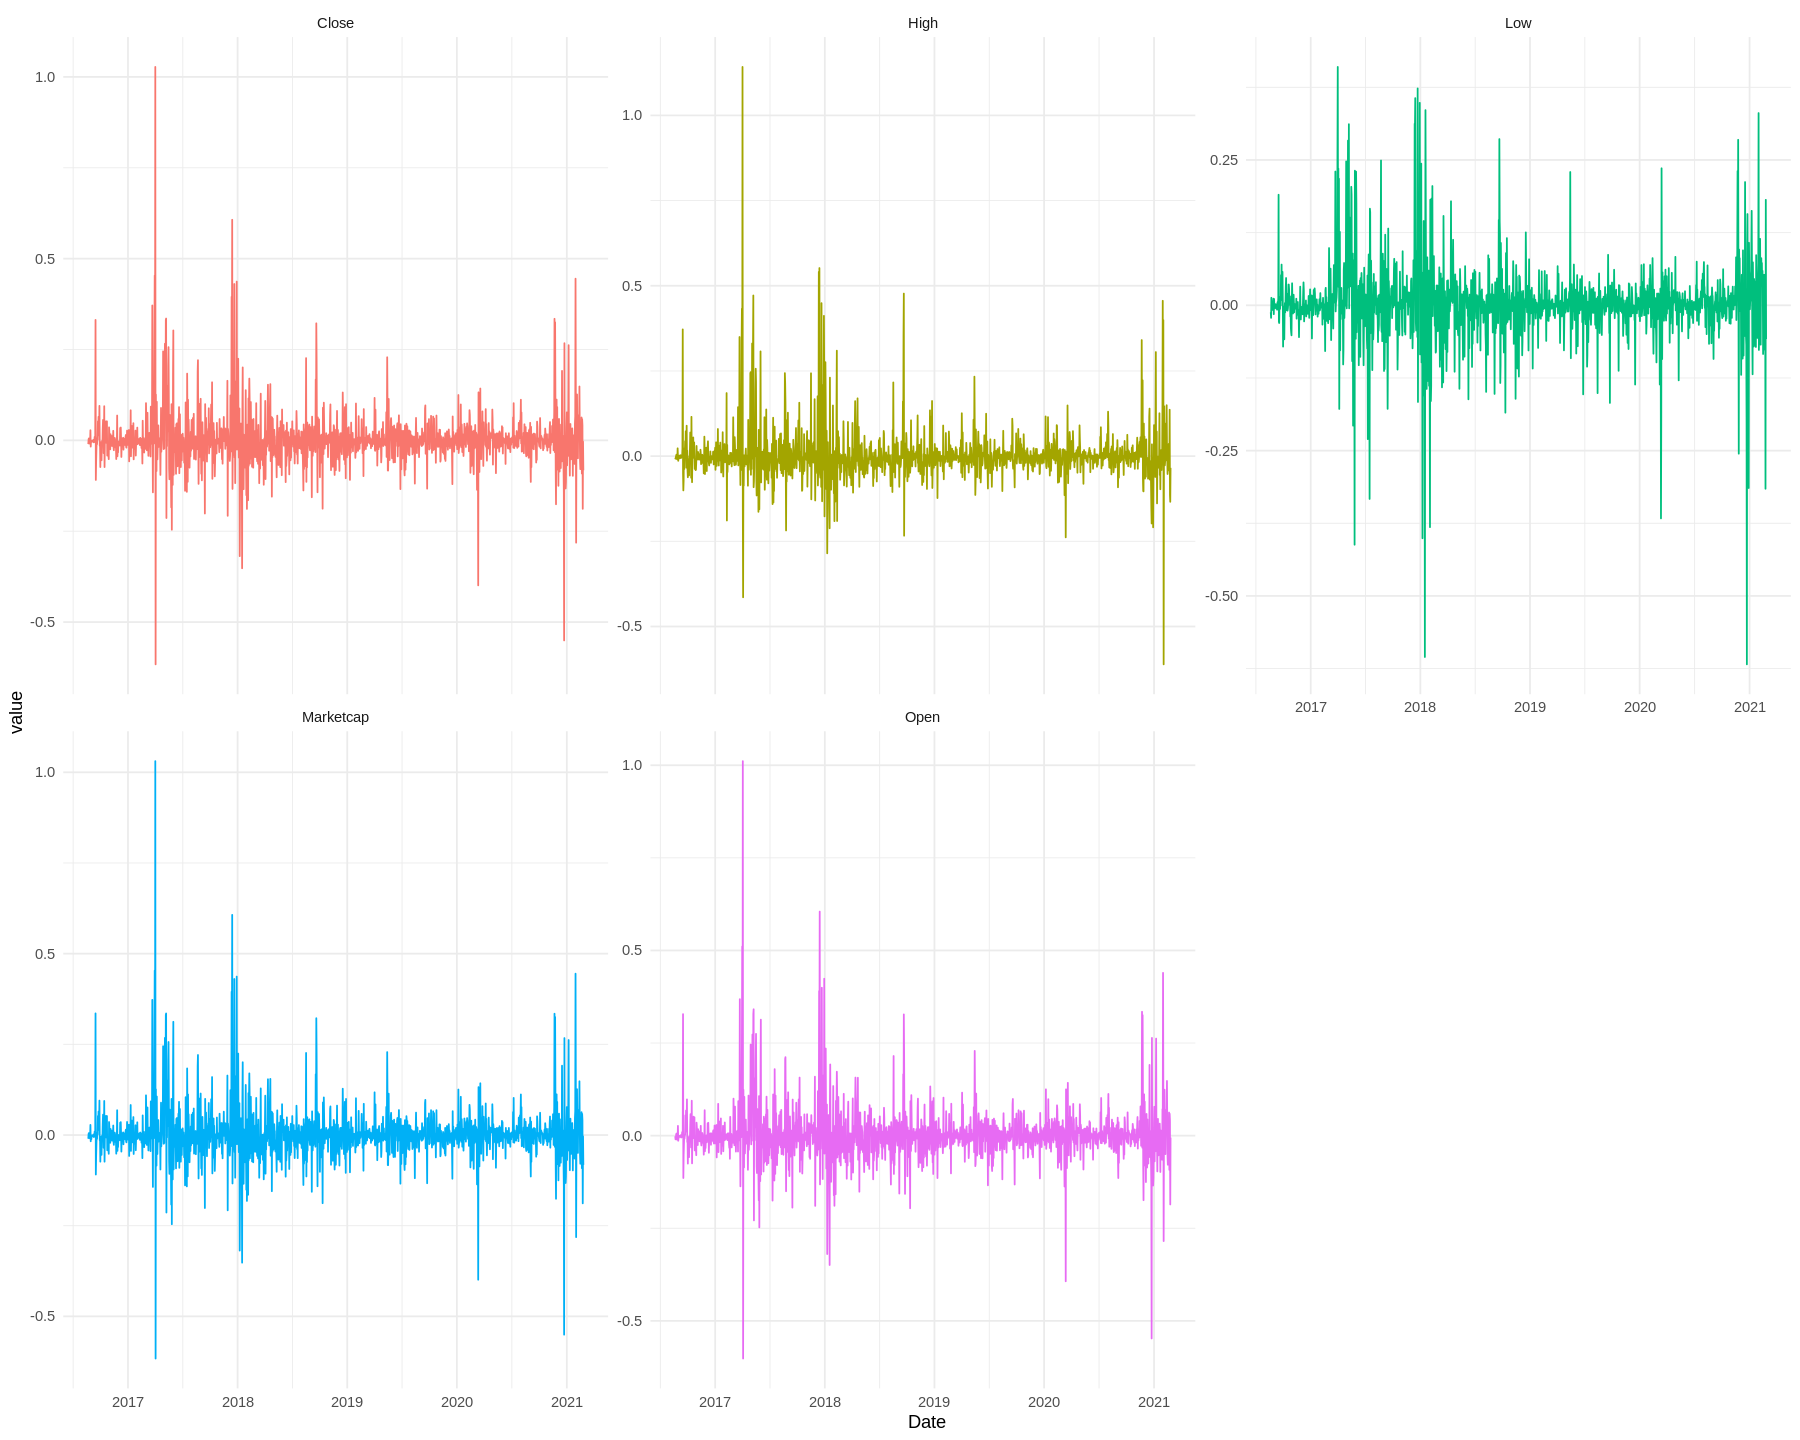

In [ ]:
model_data %>%
    pivot_longer(-Date) %>% 
    filter(name != "sentiment_past",
    name != "volatility_10_day") %>%
    ggplot(aes(Date, value, color = name)) +
    geom_line() +
    facet_wrap(~name, scales = "free_y") +
    theme_minimal() +
    theme(legend.position = "none")

In [ ]:
model_data %>% head

Date,Close,High,Low,Open,Marketcap,sentiment_past,volatility_10_day
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-08-21,-0.010235431,-0.0049278968,-0.012074565,-0.001602698,-0.010235457,0,0.01236454
2016-08-22,-0.008554772,-0.0074607249,-0.021611397,-0.009956067,-0.008554755,0,0.01215199
2016-08-23,0.003204815,-0.0029673004,0.012932516,-0.008937577,0.003204779,0,0.01210475
2016-08-24,0.005318562,0.0007942627,0.004864106,0.002256855,0.005318580,0,0.01191497
2016-08-25,0.004552119,0.0042805239,0.006577199,0.005567066,0.004570588,0,0.01173049
2016-08-26,-0.008083099,0.0020571550,-0.001592106,0.005651231,-0.008083088,0,0.01156038


In [ ]:
model_data_returns <- model_data %>%
  # Return calculation can be done in-sample
  mutate_at(vars(sentiment_past, volatility_10_day), ~.x / lag(.x) - 1) %>%
  mutate(sentiment_past = ifelse(sentiment_past == Inf | sentiment_past == -Inf, 
                                 0,
                                 sentiment_past),
        sentiment_past = replace_na(sentiment_past, 0),
        volatility_10_day = replace_na(volatility_10_day, 0))

In [ ]:
model_data_returns %>% nrow

[1] 1650

In [ ]:
model_data_returns$sentiment_past %>% summary

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-2.79363  0.00000  0.00000 -0.06929  0.00000  0.79769 

In [ ]:
model_data_returns$volatility_10_day %>% summary

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.729631 -0.036716  0.000122  0.033365  0.032977 19.003660 

In [ ]:
model_data$volatility_10_day %>% summary()

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.002009 0.025775 0.039950 0.056454 0.060735 0.614700 

In [ ]:
model_data_no_lag <- model_data_returns %>% 
    ungroup() %>%
    mutate_at(vars(-Date),
              ~ifelse(.x == Inf, 0, .x)) %>%
    ungroup()

model_target <- model_data_returns %>%
    inner_join(model_data_no_lag %>% # FIXME
                   select(Date)) %>%
    arrange(Date) %>%
    select(Date, volatility_10_day) %>%
    na.omit()

Joining, by = "Date"



In [ ]:
model_data_no_lag %>% summary

      Date                Close                High          
 Min.   :2016-08-21   Min.   :-0.616288   Min.   :-0.611076  
 1st Qu.:2017-10-07   1st Qu.:-0.021172   1st Qu.:-0.022138  
 Median :2018-11-23   Median :-0.002124   Median :-0.004366  
 Mean   :2018-11-23   Mean   : 0.002584   Mean   : 0.002644  
 3rd Qu.:2020-01-09   3rd Qu.: 0.019693   3rd Qu.: 0.013338  
 Max.   :2021-02-25   Max.   : 1.027379   Max.   : 1.142218  
      Low                 Open             Marketcap         sentiment_past    
 Min.   :-0.617696   Min.   :-0.601723   Min.   :-0.616288   Min.   :-2.79363  
 1st Qu.:-0.013757   1st Qu.:-0.021740   1st Qu.:-0.021055   1st Qu.: 0.00000  
 Median : 0.002088   Median :-0.001719   Median :-0.002069   Median : 0.00000  
 Mean   : 0.002579   Mean   : 0.002633   Mean   : 0.002732   Mean   :-0.06929  
 3rd Qu.: 0.019460   3rd Qu.: 0.020089   3rd Qu.: 0.019790   3rd Qu.: 0.00000  
 Max.   : 0.410071   Max.   : 1.010980   Max.   : 1.030730   Max.   : 0.79769  
 volat

In [ ]:
# Min-max scale
train_scaled <- model_data_no_lag %>%
    #slice(1:train_size) %>%
    mutate_if(is.numeric, ~min_max_normalize(.x, .x)) %>%
    na.omit()

In [ ]:
#first_value <- model_data_temp %>%
#  pull(volatility_10_day) %>%
#  first()
  
#last_value <- last(cumprod(train_y + 1))

In [ ]:
#first_value * last_value * 
#                              c(rep(NA, length(train_y)), 
#                               cumprod(predict(model_lstm, train_x)))

In [ ]:
# train_y_denormalized <- train_scaled %>% 
#   pull(volatility_10_day) %>% 
#   min_max_denormalize(bitcoin_data_no_lag$volatility_10_day) + 1

In [ ]:
# mutate_at(vars(sentiment_past, volatility_10_day), ~.x / lag(.x) - 1)

In [ ]:
train_scaled

Date,Close,High,Low,Open,Marketcap,sentiment_past,volatility_10_day
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-08-21,0.3687198,0.3457197,0.5892597,0.3721210,0.3679696,0.777883,0.036974639
2016-08-22,0.3697424,0.3442751,0.5799805,0.3669413,0.3689900,0.777883,0.036103531
2016-08-23,0.3768968,0.3468379,0.6135912,0.3675728,0.3761299,0.777883,0.036777634
2016-08-24,0.3781828,0.3489833,0.6057407,0.3745142,0.3774133,0.777883,0.036180150
2016-08-25,0.3777165,0.3509717,0.6074076,0.3765668,0.3769592,0.777883,0.036189989
2016-08-26,0.3700293,0.3497036,0.5994590,0.3766190,0.3692764,0.777883,0.036239793
2016-08-27,0.3693257,0.3433186,0.5932419,0.3664162,0.3685742,0.777883,0.035738956
2016-08-28,0.3737340,0.3446419,0.5983745,0.3685840,0.3729736,0.777883,0.037063534
2016-08-29,0.3918742,0.3615894,0.5983051,0.3718076,0.3910768,0.777883,0.008677179


In [ ]:
# Make lagged variables and put the values to matching positions
train_x <- train_scaled %>%
  select(-Date, -volatility_10_day) %>%
  as.matrix()

train_y <- model_target %>% 
  inner_join(train_scaled %>%
                select(Date)) %>%
  pull(volatility_10_day)

Joining, by = "Date"



In [ ]:
train_scaled %>% nrow

[1] 1650

In [ ]:
crypto_volatilities %>%head

X,run_dir,metric_loss,metric_mse,metric_val_loss,metric_val_mse,flag_units1,flag_activation1,flag_recurrent_activation1,flag_recurrent_dropout1,⋯,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,return,volatility_10_day
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<int>,⋯,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,BNB,2017-07-26,0.10901300,0.09926550,0.10589300,0.10513800,200395,10513800,NA,0.06973561
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,BTC,2013-04-29,147.48800659,134.00000000,134.44400024,144.53999329,0,1603768864,NA,0.08314241
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,ETH,2015-08-08,2.79881001,0.71472502,2.79376006,0.75332499,674188,45486894,NA,0.25153936
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,MIOTA,2017-06-14,0.60619599,0.49574500,0.59234703,0.52891600,14194900,1470138039,NA,0.12637639
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,XRP,2013-08-05,0.00597984,0.00561266,0.00587478,0.00561266,0,43879157,NA,0.07445704
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,BNB,2017-07-27,0.10847900,0.10088800,0.10510800,0.10773700,344499,10773700,0.0247199,0.06975570


In [ ]:
# val_ts_plot <- tibble(date = model_features_lagged$date,
#                       actual = first_value * c(cumprod(train_y + 1), 
#                                                last_value * cumprod(test_y + 1)),
#                       pred = first_value * last_value * 
#                         c(rep(NA, length(train_y)), 
#                           cumprod(predict(model_test, test_x) + 1)))


In [ ]:
cor(train_x %>%
    as_tibble() %>%
    mutate(volatility_10_day = train_y))

,Close,High,Low,Open,Marketcap,sentiment_past,volatility_10_day
Close,1.000000000,0.68956102,0.51714913,-0.02087738,0.999859177,-0.002721977,-0.029112974
High,0.689561023,1.00000000,0.41801120,0.41128734,0.689652914,-0.002211670,-0.064648869
Low,0.517149135,0.41801120,1.00000000,0.51079341,0.516853528,-0.010192291,0.011666955
Open,-0.020877375,0.41128734,0.51079341,1.00000000,-0.020567666,-0.027347653,-0.010609898
Marketcap,0.999859177,0.68965291,0.51685353,-0.02056767,1.000000000,-0.002493905,-0.028951840
sentiment_past,-0.002721977,-0.00221167,-0.01019229,-0.02734765,-0.002493905,1.000000000,0.007778016
volatility_10_day,-0.029112974,-0.06464887,0.01166696,-0.01060990,-0.028951840,0.007778016,1.000000000


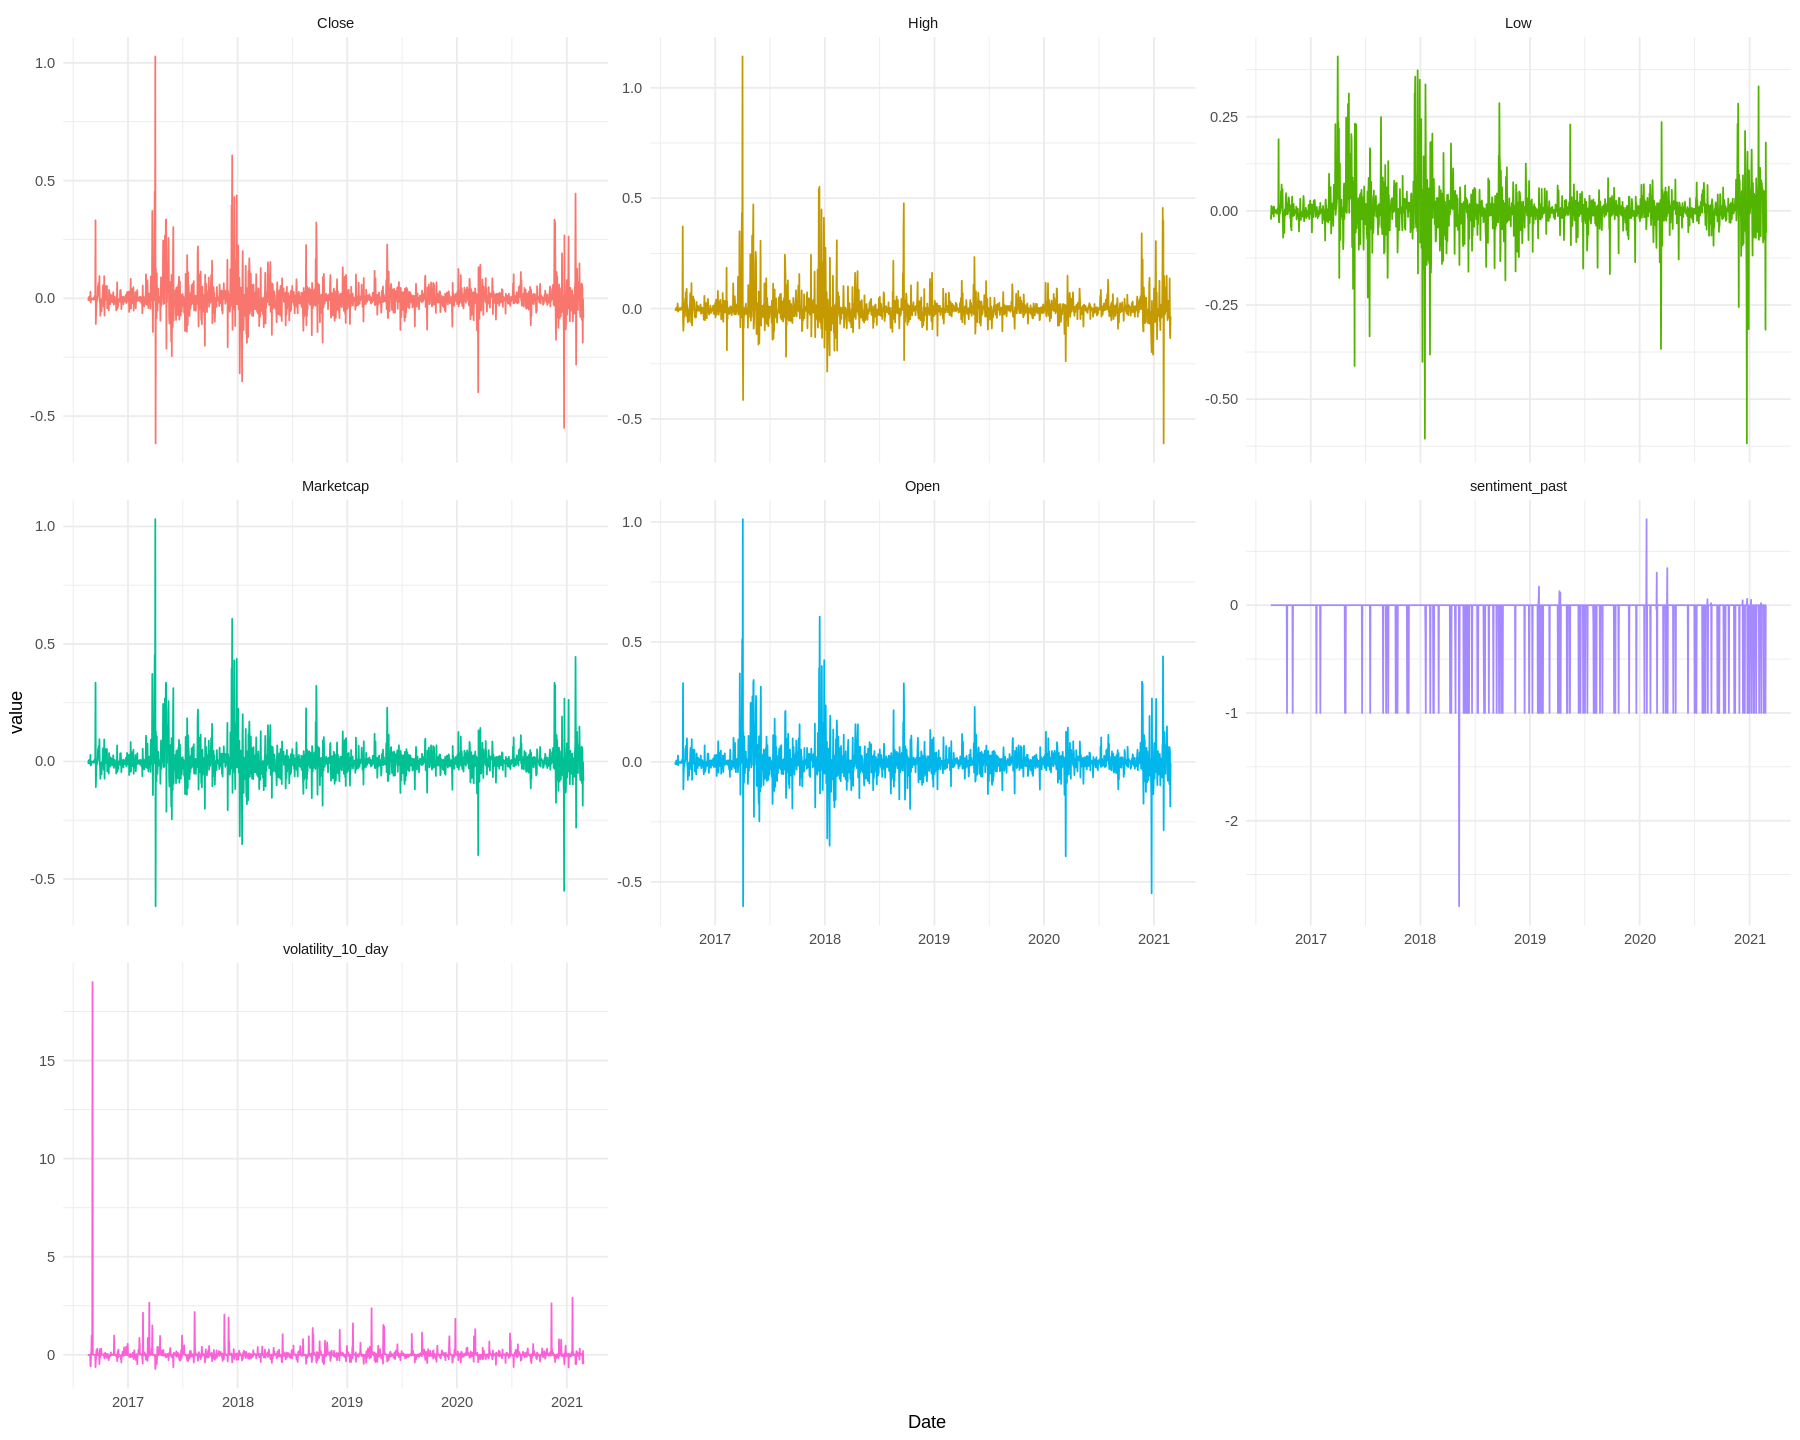

In [ ]:
model_data_no_lag %>% 
    pivot_longer(-Date) %>% 
    ggplot(aes(Date, value, color = name)) +
    geom_line() +
    facet_wrap(~name, scales = "free_y") +
    theme_minimal() +
    theme(legend.position = "none")

In [ ]:
# first_value <- df %>%
#   filter(name == selected_coin_name) %>% 
#   slice((nrow(.) - (train_size + test_size) + 1 - n_lag):I(nrow(.))) %>%
#   inner_join(model_target %>%
#                select(date)) %>%
#   pull(close) %>%
#   first()
# last_value <- last(cumprod(train_y + 1))

In [ ]:
# Set the dimensions as required by TensorFlow
dim(train_x) <- c(nrow(train_x), ncol(train_x), 1)

In [ ]:
install.packages("tfruns")
library(tfruns)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Time difference of 2.045748 secs


Final epoch (plot to see history):
    loss: 0.3398
     mse: 0.3398
val_loss: 0.07571
 val_mse: 0.07571 

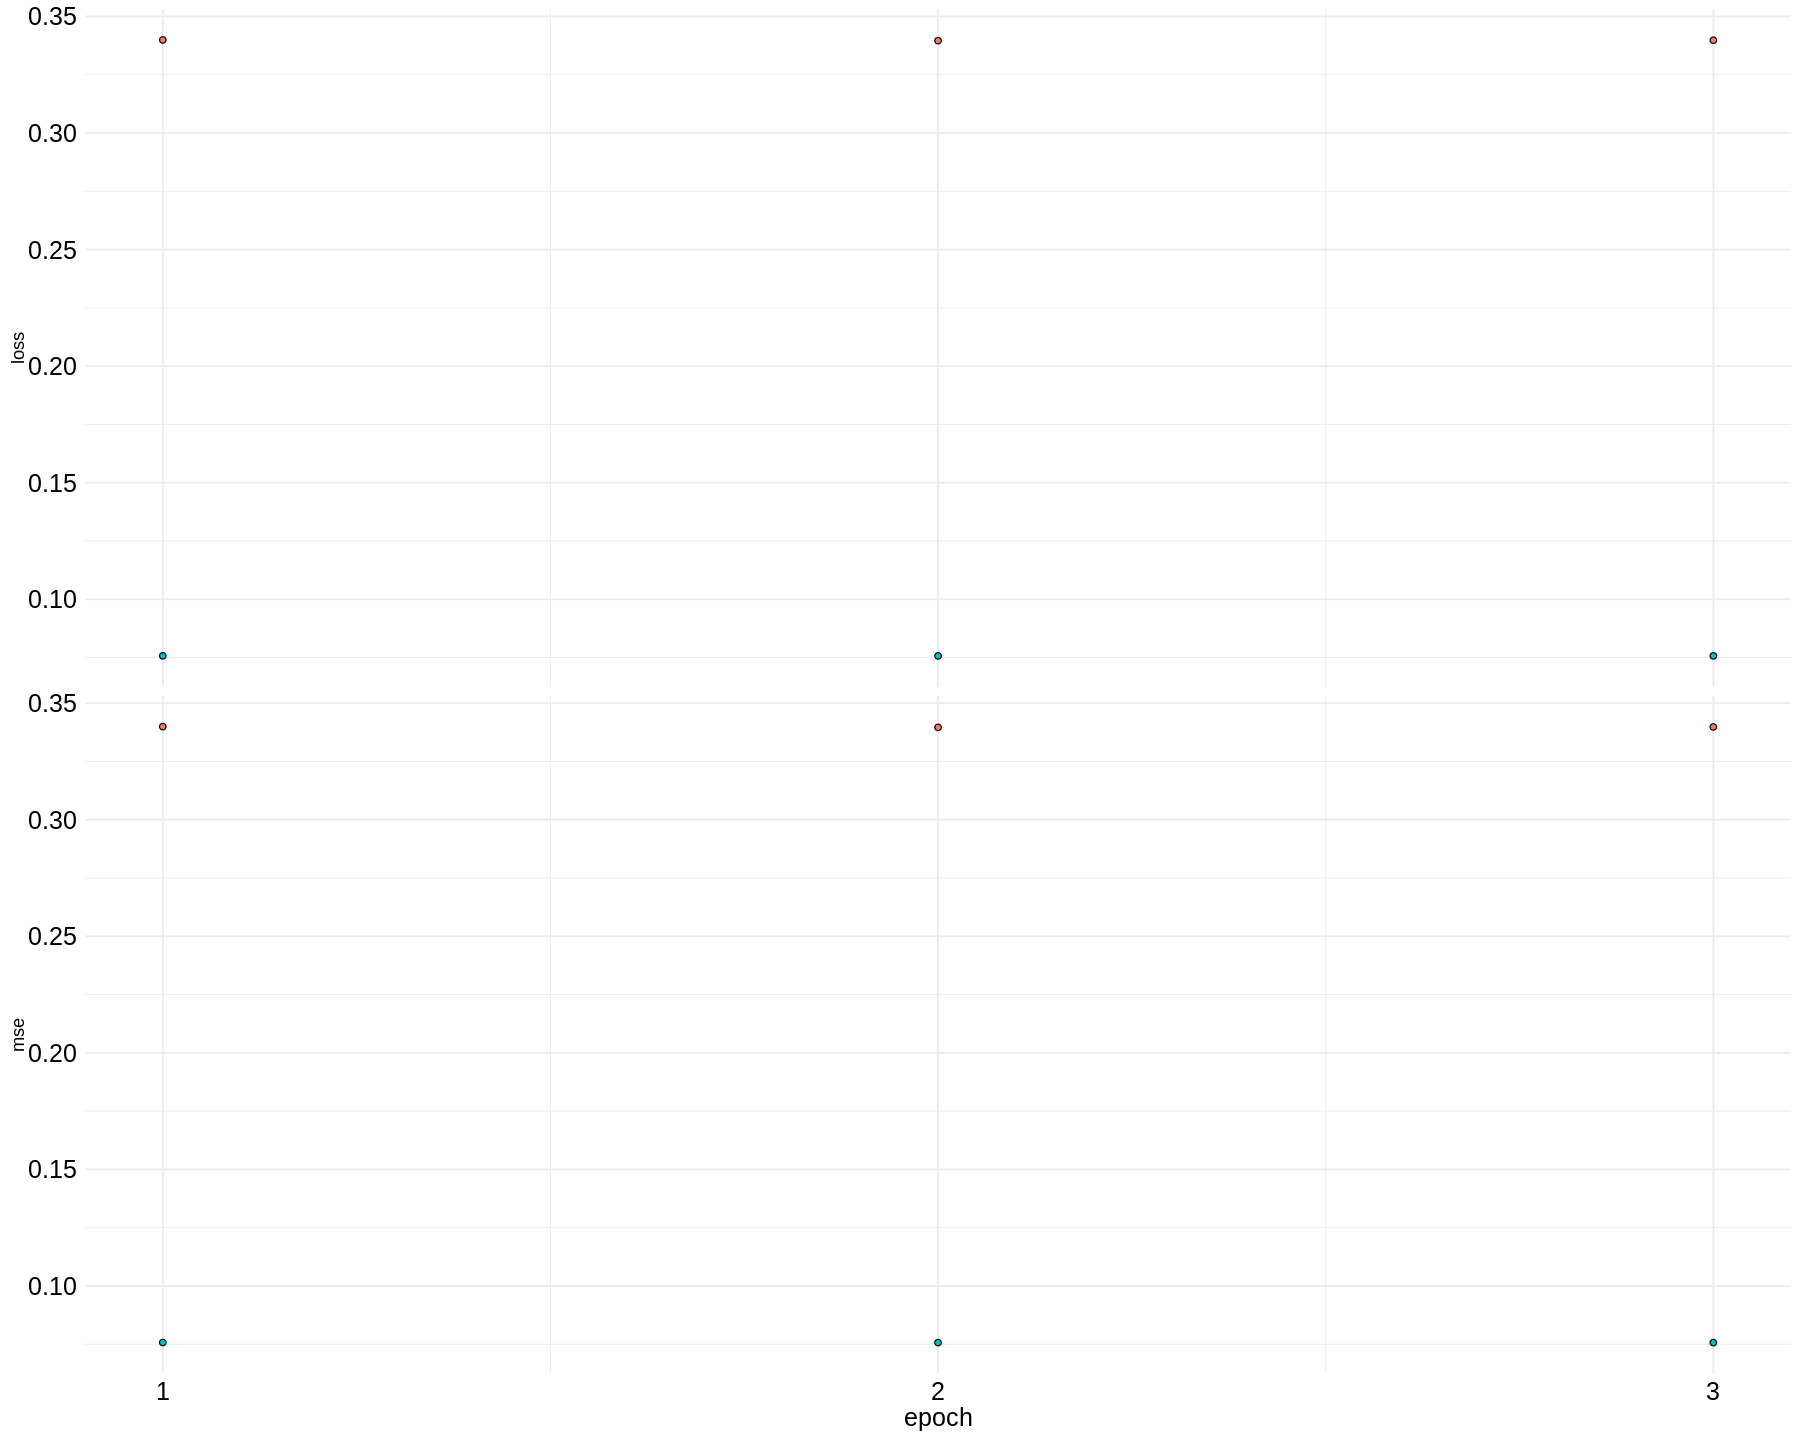

In [ ]:
# LSTM -------------------------------------------------------------------Training run 84/84 (flags = list(64, "tanh", "sigmoid", 0, 0.5, 32, 15, "mse", "adam", "mse"))
model_lstm <- keras_model_sequential()
batch_size <- 64
epochs <- 3
n_lags <- "Dont know"
loss="mse"
optimizer="adam"
metrics= c("mse")

first_layer <- "Lstm"
units1 <- 32
activation1 <- "tanh"
recurrent_activation1 <- "sigmoid"
recurrent_dropout1 <- 0
unroll1 = FALSE

second_layer =NA# "Lstm"
units2 <-NA# 5
activation2 <-NA# "tanh"
recurrent_activation2 <-NA#"sigmoid"
recurrent_dropout2 <-NA# 0
unroll2 =NA#FALSE

third_layer = NA
units3 <-NA # 10
activation3 <-NA #  "tanh"
recurrent_activation3 <-NA # "sigmoid"
recurrent_dropout3 <-NA # 0
unroll3 =NA# FALSE



model_lstm %>%
    # Hyperparameter
    layer_lstm(units = units1, # Hyperparameter
               activation = activation1, # Hyperparameter
               recurrent_activation = activation1,
               recurrent_dropout = recurrent_dropout1,
               dropout=0.25,
               unroll = unroll1,
               #return_sequences = TRUE, # TRUE when multiple layers
               use_bias = TRUE) %>%
                #     layer_lstm(units = units2, # Hyperparameter
                # activation = activation2, # Hyperparameter
                # recurrent_activation = activation2,
                # recurrent_dropout = recurrent_dropout2,
                # unroll = unroll2,
                # #return_sequences = TRUE, # TRUE when multiple layers
                # use_bias = TRUE) %>%
    layer_dense(units = 1)

model_lstm %>%
    compile(loss = loss, # Hyperparameter
            optimizer = optimizer, # Hyperparameter
            metrics = metrics)

tic <- Sys.time()
history_lstm <- model_lstm %>% fit(x = train_x,
                                   y = train_y,
                                   batch_size = batch_size,
                                   epochs = epochs,
                                   callbacks = callback_tensorboard("logs/l"),
                                   verbose = 1,
                                   validation_split = 0.2)
(toc <- Sys.time() - tic)

plot(history_lstm)

history_lstm

val_loss <- min(history_lstm$metrics$val_loss) 
optimal <- which.min(history_lstm$metrics$val_loss) 
overfit <- optimal<epochs

current <- c(val_loss, batch_size, epochs, n_lag, loss, optimizer, metrics, 
            first_layer, units1, activation1, recurrent_activation1, recurrent_dropout1, unroll1,
            second_layer, units2, activation2, recurrent_activation2, recurrent_dropout2, unroll2,
            third_layer, units3, activation3, recurrent_activation3, recurrent_dropout3, unroll3,
            optimal, overfit)

#log <- rbind(log, current)
#log
#write.csv(log, "ethlog.csv")

In [ ]:
# LSTM / GRU -------------------------------------------------------------------


# Petter custom tuning

# Hyperparameter tuning
runs <- tuning_run("1_layer_gru.R", flags = list(units1 = c(3, 8,16, 32),
                                                  activation1 =c("tanh"),
                                                  recurrent_activation1 = c("hard_sigmoid"),
                                                  recurrent_dropout1=0,
                                                  dropout1=c(0,  0.25, 0.5),
                                                  batch_size=c(64),
                                                  epochs=c(3000),
                                                  loss=c("mse"),
                                                  optimizer=c("adam"),
                                                  metrics=c("mse") ))

12 total combinations of flags 

(use sample parameter to run a random subset)

Training run 1/12 (flags = list(3, "tanh", "hard_sigmoid", 0, 0, 64, 3000, "mse", "adam", ) Training run 1/12 (flags =     "mse")) 

Using run directory runs/2021-04-15T23-43-00Z




> FLAGS <- flags(flag_integer("units1", 4), flag_string("activation1", 
+     "tanh"), flag_string("recurrent_activation1", "hard_sigmoid"), 
+     fl .... [TRUNCATED] 

> model <- keras_model_sequential() %>% layer_gru(units = FLAGS$units1, 
+     activation = FLAGS$activation1, recurrent_activation = FLAGS$recurrent_ .... [TRUNCATED] 

> model_lstm %>% compile(loss = FLAGS$loss, optimizer = FLAGS$optimizer, 
+     metrics = FLAGS$metrics)

> tic <- Sys.time()

> history_lstm <- model_lstm %>% fit(x = train_x, y = train_y, 
+     batch_size = FLAGS$batch_size, epochs = FLAGS$epochs, verbose = 1, 
+     valida .... [TRUNCATED] 



Run completed: runs/2021-04-15T23-43-00Z


Training run 2/12 (flags = list(8, "tanh", "hard_sigmoid", 0, 0, 64, 3000, "mse", "adam", ) Training run 2/12 (flags =     "mse")) 

Using run directory runs/2021-04-15T23-44-17Z




> FLAGS <- flags(flag_integer("units1", 4), flag_string("activation1", 
+     "tanh"), flag_string("recurrent_activation1", "hard_sigmoid"), 
+     fl .... [TRUNCATED] 

> model <- keras_model_sequential() %>% layer_gru(units = FLAGS$units1, 
+     activation = FLAGS$activation1, recurrent_activation = FLAGS$recurrent_ .... [TRUNCATED] 

> model_lstm %>% compile(loss = FLAGS$loss, optimizer = FLAGS$optimizer, 
+     metrics = FLAGS$metrics)

> tic <- Sys.time()

> history_lstm <- model_lstm %>% fit(x = train_x, y = train_y, 
+     batch_size = FLAGS$batch_size, epochs = FLAGS$epochs, verbose = 1, 
+     valida .... [TRUNCATED] 



Run completed: runs/2021-04-15T23-44-17Z


Training run 3/12 (flags = list(16, "tanh", "hard_sigmoid", 0, 0, 64, 3000, "mse", "adam", ) Training run 3/12 (flags =     "mse")) 

Using run directory runs/2021-04-15T23-46-31Z




> FLAGS <- flags(flag_integer("units1", 4), flag_string("activation1", 
+     "tanh"), flag_string("recurrent_activation1", "hard_sigmoid"), 
+     fl .... [TRUNCATED] 

> model <- keras_model_sequential() %>% layer_gru(units = FLAGS$units1, 
+     activation = FLAGS$activation1, recurrent_activation = FLAGS$recurrent_ .... [TRUNCATED] 

> model_lstm %>% compile(loss = FLAGS$loss, optimizer = FLAGS$optimizer, 
+     metrics = FLAGS$metrics)

> tic <- Sys.time()

> history_lstm <- model_lstm %>% fit(x = train_x, y = train_y, 
+     batch_size = FLAGS$batch_size, epochs = FLAGS$epochs, verbose = 1, 
+     valida .... [TRUNCATED] 



Run completed: runs/2021-04-15T23-46-31Z


Training run 4/12 (flags = list(32, "tanh", "hard_sigmoid", 0, 0, 64, 3000, "mse", "adam", ) Training run 4/12 (flags =     "mse")) 

Using run directory runs/2021-04-15T23-50-37Z




> FLAGS <- flags(flag_integer("units1", 4), flag_string("activation1", 
+     "tanh"), flag_string("recurrent_activation1", "hard_sigmoid"), 
+     fl .... [TRUNCATED] 

> model <- keras_model_sequential() %>% layer_gru(units = FLAGS$units1, 
+     activation = FLAGS$activation1, recurrent_activation = FLAGS$recurrent_ .... [TRUNCATED] 

> model_lstm %>% compile(loss = FLAGS$loss, optimizer = FLAGS$optimizer, 
+     metrics = FLAGS$metrics)

> tic <- Sys.time()

> history_lstm <- model_lstm %>% fit(x = train_x, y = train_y, 
+     batch_size = FLAGS$batch_size, epochs = FLAGS$epochs, verbose = 1, 
+     valida .... [TRUNCATED] 



Run completed: runs/2021-04-15T23-50-37Z


Training run 5/12 (flags = list(3, "tanh", "hard_sigmoid", 0, 0.25, 64, 3000, "mse", "adam", ) Training run 5/12 (flags =     "mse")) 

Using run directory runs/2021-04-15T23-52-58Z




> FLAGS <- flags(flag_integer("units1", 4), flag_string("activation1", 
+     "tanh"), flag_string("recurrent_activation1", "hard_sigmoid"), 
+     fl .... [TRUNCATED] 

> model <- keras_model_sequential() %>% layer_gru(units = FLAGS$units1, 
+     activation = FLAGS$activation1, recurrent_activation = FLAGS$recurrent_ .... [TRUNCATED] 

> model_lstm %>% compile(loss = FLAGS$loss, optimizer = FLAGS$optimizer, 
+     metrics = FLAGS$metrics)

> tic <- Sys.time()

> history_lstm <- model_lstm %>% fit(x = train_x, y = train_y, 
+     batch_size = FLAGS$batch_size, epochs = FLAGS$epochs, verbose = 1, 
+     valida .... [TRUNCATED] 



Run completed: runs/2021-04-15T23-52-58Z


Training run 6/12 (flags = list(8, "tanh", "hard_sigmoid", 0, 0.25, 64, 3000, "mse", "adam", ) Training run 6/12 (flags =     "mse")) 

Using run directory runs/2021-04-15T23-54-51Z




> FLAGS <- flags(flag_integer("units1", 4), flag_string("activation1", 
+     "tanh"), flag_string("recurrent_activation1", "hard_sigmoid"), 
+     fl .... [TRUNCATED] 

> model <- keras_model_sequential() %>% layer_gru(units = FLAGS$units1, 
+     activation = FLAGS$activation1, recurrent_activation = FLAGS$recurrent_ .... [TRUNCATED] 

> model_lstm %>% compile(loss = FLAGS$loss, optimizer = FLAGS$optimizer, 
+     metrics = FLAGS$metrics)

> tic <- Sys.time()

> history_lstm <- model_lstm %>% fit(x = train_x, y = train_y, 
+     batch_size = FLAGS$batch_size, epochs = FLAGS$epochs, verbose = 1, 
+     valida .... [TRUNCATED] 



Run completed: runs/2021-04-15T23-54-51Z


Training run 7/12 (flags = list(16, "tanh", "hard_sigmoid", 0, 0.25, 64, 3000, "mse", "adam", ) Training run 7/12 (flags =     "mse")) 

Using run directory runs/2021-04-15T23-57-23Z




> FLAGS <- flags(flag_integer("units1", 4), flag_string("activation1", 
+     "tanh"), flag_string("recurrent_activation1", "hard_sigmoid"), 
+     fl .... [TRUNCATED] 

> model <- keras_model_sequential() %>% layer_gru(units = FLAGS$units1, 
+     activation = FLAGS$activation1, recurrent_activation = FLAGS$recurrent_ .... [TRUNCATED] 

> model_lstm %>% compile(loss = FLAGS$loss, optimizer = FLAGS$optimizer, 
+     metrics = FLAGS$metrics)

> tic <- Sys.time()

> history_lstm <- model_lstm %>% fit(x = train_x, y = train_y, 
+     batch_size = FLAGS$batch_size, epochs = FLAGS$epochs, verbose = 1, 
+     valida .... [TRUNCATED] 



Run completed: runs/2021-04-15T23-57-23Z


Training run 8/12 (flags = list(32, "tanh", "hard_sigmoid", 0, 0.25, 64, 3000, "mse", "adam", ) Training run 8/12 (flags =     "mse")) 

Using run directory runs/2021-04-15T23-58-30Z




> FLAGS <- flags(flag_integer("units1", 4), flag_string("activation1", 
+     "tanh"), flag_string("recurrent_activation1", "hard_sigmoid"), 
+     fl .... [TRUNCATED] 

> model <- keras_model_sequential() %>% layer_gru(units = FLAGS$units1, 
+     activation = FLAGS$activation1, recurrent_activation = FLAGS$recurrent_ .... [TRUNCATED] 

> model_lstm %>% compile(loss = FLAGS$loss, optimizer = FLAGS$optimizer, 
+     metrics = FLAGS$metrics)

> tic <- Sys.time()

> history_lstm <- model_lstm %>% fit(x = train_x, y = train_y, 
+     batch_size = FLAGS$batch_size, epochs = FLAGS$epochs, verbose = 1, 
+     valida .... [TRUNCATED] 



Run completed: runs/2021-04-15T23-58-30Z


Training run 9/12 (flags = list(3, "tanh", "hard_sigmoid", 0, 0.5, 64, 3000, "mse", "adam", ) Training run 9/12 (flags =     "mse")) 

Using run directory runs/2021-04-16T00-00-37Z




> FLAGS <- flags(flag_integer("units1", 4), flag_string("activation1", 
+     "tanh"), flag_string("recurrent_activation1", "hard_sigmoid"), 
+     fl .... [TRUNCATED] 

> model <- keras_model_sequential() %>% layer_gru(units = FLAGS$units1, 
+     activation = FLAGS$activation1, recurrent_activation = FLAGS$recurrent_ .... [TRUNCATED] 

> model_lstm %>% compile(loss = FLAGS$loss, optimizer = FLAGS$optimizer, 
+     metrics = FLAGS$metrics)

> tic <- Sys.time()

> history_lstm <- model_lstm %>% fit(x = train_x, y = train_y, 
+     batch_size = FLAGS$batch_size, epochs = FLAGS$epochs, verbose = 1, 
+     valida .... [TRUNCATED] 



Run completed: runs/2021-04-16T00-00-37Z


Training run 10/12 (flags = list(8, "tanh", "hard_sigmoid", 0, 0.5, 64, 3000, "mse", "adam", ) Training run 10/12 (flags =     "mse")) 

Using run directory runs/2021-04-16T00-01-57Z




> FLAGS <- flags(flag_integer("units1", 4), flag_string("activation1", 
+     "tanh"), flag_string("recurrent_activation1", "hard_sigmoid"), 
+     fl .... [TRUNCATED] 

> model <- keras_model_sequential() %>% layer_gru(units = FLAGS$units1, 
+     activation = FLAGS$activation1, recurrent_activation = FLAGS$recurrent_ .... [TRUNCATED] 

> model_lstm %>% compile(loss = FLAGS$loss, optimizer = FLAGS$optimizer, 
+     metrics = FLAGS$metrics)

> tic <- Sys.time()

> history_lstm <- model_lstm %>% fit(x = train_x, y = train_y, 
+     batch_size = FLAGS$batch_size, epochs = FLAGS$epochs, verbose = 1, 
+     valida .... [TRUNCATED] 



Run completed: runs/2021-04-16T00-01-57Z


Training run 11/12 (flags = list(16, "tanh", "hard_sigmoid", 0, 0.5, 64, 3000, "mse", "adam", ) Training run 11/12 (flags =     "mse")) 

Using run directory runs/2021-04-16T00-05-00Z




> FLAGS <- flags(flag_integer("units1", 4), flag_string("activation1", 
+     "tanh"), flag_string("recurrent_activation1", "hard_sigmoid"), 
+     fl .... [TRUNCATED] 

> model <- keras_model_sequential() %>% layer_gru(units = FLAGS$units1, 
+     activation = FLAGS$activation1, recurrent_activation = FLAGS$recurrent_ .... [TRUNCATED] 

> model_lstm %>% compile(loss = FLAGS$loss, optimizer = FLAGS$optimizer, 
+     metrics = FLAGS$metrics)

> tic <- Sys.time()

> history_lstm <- model_lstm %>% fit(x = train_x, y = train_y, 
+     batch_size = FLAGS$batch_size, epochs = FLAGS$epochs, verbose = 1, 
+     valida .... [TRUNCATED] 



Run completed: runs/2021-04-16T00-05-00Z


Training run 12/12 (flags = list(32, "tanh", "hard_sigmoid", 0, 0.5, 64, 3000, "mse", "adam", ) Training run 12/12 (flags =     "mse")) 

Using run directory runs/2021-04-16T00-06-50Z




> FLAGS <- flags(flag_integer("units1", 4), flag_string("activation1", 
+     "tanh"), flag_string("recurrent_activation1", "hard_sigmoid"), 
+     fl .... [TRUNCATED] 

> model <- keras_model_sequential() %>% layer_gru(units = FLAGS$units1, 
+     activation = FLAGS$activation1, recurrent_activation = FLAGS$recurrent_ .... [TRUNCATED] 

> model_lstm %>% compile(loss = FLAGS$loss, optimizer = FLAGS$optimizer, 
+     metrics = FLAGS$metrics)

> tic <- Sys.time()

> history_lstm <- model_lstm %>% fit(x = train_x, y = train_y, 
+     batch_size = FLAGS$batch_size, epochs = FLAGS$epochs, verbose = 1, 
+     valida .... [TRUNCATED] 



Run completed: runs/2021-04-16T00-06-50Z




In [ ]:
# write.csv(runs, "XRP_gru.csv")

In [ ]:
history_lstm
min(history_lstm$metrics$val_loss) 



Final epoch (plot to see history):
    loss: 0.3398
     mse: 0.3398
val_loss: 0.07571
 val_mse: 0.07571 

[1] 0.07570592

In [ ]:
# saveRDS(model_lstm, "model_lstm.RDS")

In [ ]:
#Load log 
#log <- read.csv("ethlog (5).csv")


In [ ]:
#Fix log
#log <- log[,-1]
#log <- log[-nrow(log),]
#log

In [ ]:
#Clear log
log <- data.frame("Val loss" = NA,
                  "Batch size"=NA,
                  "Epochs" = NA,
                  "Lags" = NA,
                  "Loss function" = NA,
                  "Optimizer" = NA,
                  "Metrics" = NA,
                  "Layer 1 type" = NA,
                  "Units 1" = NA,
                  "Activation 1" = NA,
                  "Recurrent activation 1"= NA,
                  "Recurrent dropout 1" = NA,
                  "Unroll 1" = NA,
                  "Layer 2 type" = NA,
                  "Units 2" = NA,
                  "Activation 2" = NA,
                  "Recurrent activation 2"= NA,
                  "Recurrent dropout 2" = NA,
                  "Unroll 2" = NA,
                  "Layer 3 type" = NA,
                  "Units 3" = NA,
                  "Activation 3" = NA,
                  "Recurrent activation 3"= NA,
                  "Recurrent dropout 3" = NA,
                  "Unroll 3" = NA,
                  "optimal" = NA,
                  "overfit" = NA
                  ) 

  log

In [ ]:
tribble(
    ~id, ~Layer1, ~U1, ~D1, ~Layer2, ~U2, ~D2, ~Layer3, ~U3, ~Epochs, ~n_lag, ~Batch, ~Activation, ~Function, ~Optimizer, ~lr,   ~Optimal, ~Overfit, ~val_loss,
    1,    "LSTM",  20,  0.5, NA,      NA,  NA,      NA,  NA,  3000,    20,     64,     "tanh",      "mse",     "adam",     NA,    14,       TRUE,     0.0217,
    2,    "LSTM",  20,  0.2, NA,      NA,  NA,      NA,  NA,  100,     20,     64,     "tanh",      "mse",     "adam",     NA,    70,       TRUE,     0.0201)

# **Write the results from the model in the code cell above**
---
**id**: Order number of the run

**Layer1-3**: names of layers used for each possible layer, LSTM/GRU/etc.

**U1-3**: how many units each layer had for all the existing layers

**Epochs**: total number of epochs ran

**N_lag**: number of lags used for the predictors

**Batch**: batch size used in training

**Activation**: the activation function, tanh/relu/sigmoid/etc.

**Function**: the loss function, mse/mean_absolute_error/etc.

**Optimizer**: adam/RMSProp/SGD/etc.

**lr**: learning rate, if one is not set automatically by adam

**Optimal**: the optimal number of epochs as shown in the cell above

**Overfit**: did the model overfit with the amount of epochs used, i.e. did the blue line in the first plot start going up after some point?

**val_loss**: validation loss, this should be minimized

In [ ]:
plot(history_lstm)

In [ ]:
history_lstm

In [ ]:
model_data_returns %>% summary

In [ ]:
# Custom ALE function
custom_ale <- function(X, X.model, pred.fun, J, K = 40, NA.plot = TRUE){
  N = dim(X)[1]
  d = dim(X)[2]
  if (length(J) == 1) {
    if (class(X[, J]) == "factor") {
      X[, J] <- droplevels(X[, J])
      x.count <- as.numeric(table(X[, J]))
      x.prob <- x.count / sum(x.count)
      K <- nlevels(X[, J])
      D.cum <- matrix(0, K, K)
      D <- matrix(0, K, K)
      for (j in setdiff(1:d, J)) {
        if (class(X[, j]) == "factor") {
          A = table(X[, J], X[, j])
          A = A / x.count
          for (i in 1:(K - 1)) {
            for (k in (i + 1):K) {
              D[i, k] = sum(abs(A[i,] - A[k,])) / 2
              D[k, i] = D[i, k]
            }
          }
          D.cum <- D.cum + D
        }
        else {
          q.x.all <- quantile(
            X[, j],
            probs = seq(0,
                        1, length.out = 100),
            na.rm = TRUE,
            names = FALSE
          )
          x.ecdf = tapply(X[, j], X[, J], ecdf)
          for (i in 1:(K - 1)) {
            for (k in (i + 1):K) {
              D[i, k] = max(abs(x.ecdf[[i]](q.x.all) -
                                  x.ecdf[[k]](q.x.all)))
              D[k, i] = D[i, k]
            }
          }
          D.cum <- D.cum + D
        }
      }
      D1D <- cmdscale(D.cum, k = 1)
      ind.ord <- sort(D1D, index.return = T)$ix
      ord.ind <- sort(ind.ord, index.return = T)$ix
      levs.orig <- levels(X[, J])
      levs.ord <- levs.orig[ind.ord]
      x.ord <- ord.ind[as.numeric(X[, J])]
      row.ind.plus <- (1:N)[x.ord < K]
      row.ind.neg <- (1:N)[x.ord > 1]
      X.plus <- X
      X.neg <- X
      X.plus[row.ind.plus, J] <- levs.ord[x.ord[row.ind.plus] +
                                            1]
      X.neg[row.ind.neg, J] <- levs.ord[x.ord[row.ind.neg] -
                                          1]
      y.hat <- pred.fun(X.model = X.model, newdata = X)
      y.hat.plus <-
        pred.fun(X.model = X.model, newdata = X.plus[row.ind.plus,])
      y.hat.neg <-
        pred.fun(X.model = X.model, newdata = X.neg[row.ind.neg,])
      Delta.plus <- y.hat.plus - y.hat[row.ind.plus]
      Delta.neg <- y.hat[row.ind.neg] - y.hat.neg
      Delta <- as.numeric(tapply(c(Delta.plus, Delta.neg),
                                 c(x.ord[row.ind.plus], x.ord[row.ind.neg] -
                                     1), mean))
      fJ <- c(0, cumsum(Delta))
      fJ = fJ - sum(fJ * x.prob[ind.ord])
      x <- levs.ord
    }
    else if (class(X[, J]) == "numeric" | class(X[, J]) ==
             "integer") {
      z = c(min(X[, J]), as.numeric(quantile(X[, J][X[, J] > -10000], seq(
        1 / K,
        1, length.out = K
      ), type = 1)))
      z = unique(z)
      K = length(z) - 1
      fJ = numeric(K)
      a1 = as.numeric(cut(X[, J], breaks = z, include.lowest = TRUE))
      X1 = X
      X2 = X
      X1[, J] = z[a1]
      X2[, J] = z[a1 + 1]
      y.hat1 = pred.fun(X.model = X.model, newdata = X1)
      y.hat2 = pred.fun(X.model = X.model, newdata = X2)
      Delta = y.hat2 - y.hat1
      Delta = as.numeric(tapply(Delta, a1, mean))
      fJ = c(0, cumsum(Delta))
      b1 <- as.numeric(table(a1))
      fJ = fJ - sum((fJ[1:K] + fJ[2:(K + 1)]) / 2 * b1) / sum(b1)
      x <- z
    }
    else
      print("error:  class(X[,J]) must be either factor or numeric or integer")
  }
  else if (length(J) == 2) {
    if (class(X[, J[2]]) != "numeric" & class(X[, J[2]]) !=
        "integer") {
      print("error: X[,J[2]] must be numeric or integer. Only X[,J[1]] can be a factor")
    }
    if (class(X[, J[1]]) == "factor") {
      X[, J[1]] <- droplevels(X[, J[1]])
      x.count <- as.numeric(table(X[, J[1]]))
      x.prob <- x.count / sum(x.count)
      K1 <- nlevels(X[, J[1]])
      D.cum <- matrix(0, K1, K1)
      D <- matrix(0, K1, K1)
      for (j in setdiff(1:d, J[1])) {
        if (class(X[, j]) == "factor") {
          A = table(X[, J[1]], X[, j])
          A = A / x.count
          for (i in 1:(K1 - 1)) {
            for (k in (i + 1):K1) {
              D[i, k] = sum(abs(A[i,] - A[k,])) / 2
              D[k, i] = D[i, k]
            }
          }
          D.cum <- D.cum + D
        }
        else {
          q.x.all <- quantile(
            X[, j],
            probs = seq(0,
                        1, length.out = 100),
            na.rm = TRUE,
            names = FALSE
          )
          x.ecdf = tapply(X[, j], X[, J[1]], ecdf)
          for (i in 1:(K1 - 1)) {
            for (k in (i + 1):K1) {
              D[i, k] = max(abs(x.ecdf[[i]](q.x.all) -
                                  x.ecdf[[k]](q.x.all)))
              D[k, i] = D[i, k]
            }
          }
          D.cum <- D.cum + D
        }
      }
      D1D <- cmdscale(D.cum, k = 1)
      ind.ord <- sort(D1D, index.return = T)$ix
      ord.ind <- sort(ind.ord, index.return = T)$ix
      levs.orig <- levels(X[, J[1]])
      levs.ord <- levs.orig[ind.ord]
      x.ord <- ord.ind[as.numeric(X[, J[1]])]
      z2 = c(min(X[, J[2]]), as.numeric(quantile(X[, J[2]],
                                                 seq(
                                                   1 / K, 1, length.out = K
                                                 ), type = 1)))
      z2 = unique(z2)
      K2 = length(z2) - 1
      a2 = as.numeric(cut(X[, J[2]], breaks = z2, include.lowest = TRUE))
      row.ind.plus <- (1:N)[x.ord < K1]
      X11 = X
      X12 = X
      X21 = X
      X22 = X
      X11[row.ind.plus, J[2]] = z2[a2][row.ind.plus]
      X12[row.ind.plus, J[2]] = z2[a2 + 1][row.ind.plus]
      X21[row.ind.plus, J[1]] = levs.ord[x.ord[row.ind.plus] +
                                           1]
      X22[row.ind.plus, J[1]] = levs.ord[x.ord[row.ind.plus] +
                                           1]
      X21[row.ind.plus, J[2]] = z2[a2][row.ind.plus]
      X22[row.ind.plus, J[2]] = z2[a2 + 1][row.ind.plus]
      y.hat11 = pred.fun(X.model = X.model, newdata = X11[row.ind.plus,])
      y.hat12 = pred.fun(X.model = X.model, newdata = X12[row.ind.plus,])
      y.hat21 = pred.fun(X.model = X.model, newdata = X21[row.ind.plus,])
      y.hat22 = pred.fun(X.model = X.model, newdata = X22[row.ind.plus,])
      Delta.plus = (y.hat22 - y.hat21) - (y.hat12 - y.hat11)
      row.ind.neg <- (1:N)[x.ord > 1]
      X11 = X
      X12 = X
      X21 = X
      X22 = X
      X11[row.ind.neg, J[1]] = levs.ord[x.ord[row.ind.neg] -
                                          1]
      X12[row.ind.neg, J[1]] = levs.ord[x.ord[row.ind.neg] -
                                          1]
      X11[row.ind.neg, J[2]] = z2[a2][row.ind.neg]
      X12[row.ind.neg, J[2]] = z2[a2 + 1][row.ind.neg]
      X21[row.ind.neg, J[2]] = z2[a2][row.ind.neg]
      X22[row.ind.neg, J[2]] = z2[a2 + 1][row.ind.neg]
      y.hat11 = pred.fun(X.model = X.model, newdata = X11[row.ind.neg,])
      y.hat12 = pred.fun(X.model = X.model, newdata = X12[row.ind.neg,])
      y.hat21 = pred.fun(X.model = X.model, newdata = X21[row.ind.neg,])
      y.hat22 = pred.fun(X.model = X.model, newdata = X22[row.ind.neg,])
      Delta.neg = (y.hat22 - y.hat21) - (y.hat12 - y.hat11)
      Delta = as.matrix(tapply(c(Delta.plus, Delta.neg),
                               list(c(
                                 x.ord[row.ind.plus], x.ord[row.ind.neg] -
                                   1
                               ), a2[c(row.ind.plus, row.ind.neg)]), mean))
      NA.Delta = is.na(Delta)
      NA.ind = which(NA.Delta, arr.ind = T, useNames = F)
      if (nrow(NA.ind) > 0) {
        notNA.ind = which(!NA.Delta, arr.ind = T, useNames = F)
        range1 = K1 - 1
        range2 = max(z2[z2 > -10000]) - min(z2)
        Z.NA = cbind(NA.ind[, 1] / range1,
                     (z2[NA.ind[,
                                2]] + z2[NA.ind[, 2] + 1]) /
                       2 / range2)
        Z.notNA = cbind(notNA.ind[, 1] / range1,
                        (z2[notNA.ind[,
                                      2]] + z2[notNA.ind[, 2] + 1]) /
                          2 / range2)
        nbrs <-
          ann(Z.notNA, Z.NA, k = 1, verbose = F)$knnIndexDist[,
                                                              1]
        Delta[NA.ind] = Delta[matrix(notNA.ind[nbrs,], ncol = 2)]
      }
      fJ = matrix(0, K1 - 1, K2)
      fJ = apply(t(apply(Delta, 1, cumsum)), 2, cumsum)
      fJ = rbind(rep(0, K2), fJ)
      fJ = cbind(rep(0, K1), fJ)
      b = as.matrix(table(x.ord, a2))
      b2 = apply(b, 2, sum)
      Delta = fJ[, 2:(K2 + 1)] - fJ[, 1:K2]
      b.Delta = b * Delta
      Delta.Ave = apply(b.Delta, 2, sum) / b2
      fJ2 = c(0, cumsum(Delta.Ave))
      b.ave = matrix((b[1:(K1 - 1),] + b[2:K1,]) / 2,
                     K1 - 1, K2)
      b1 = apply(b.ave, 1, sum)
      Delta = matrix(fJ[2:K1,] - fJ[1:(K1 - 1),], K1 -
                       1, K2 + 1)
      b.Delta = matrix(b.ave * (Delta[, 1:K2] + 
                                  Delta[, 2:(K2 + 1)]) / 2, K1 - 1, K2)
      Delta.Ave = apply(b.Delta, 1, sum) / b1
      fJ1 = c(0, cumsum(Delta.Ave))
      fJ = fJ - outer(fJ1, rep(1, K2 + 1)) - outer(rep(1,
                                                       K1), fJ2)
      fJ0 = sum(b * (fJ[, 1:K2] + fJ[, 2:(K2 + 1)]) / 2) / sum(b)
      fJ = fJ - fJ0
      x <- list(levs.ord, z2)
      K <- c(K1, K2)
      if (NA.plot == FALSE) {
        if (nrow(NA.ind) > 0) {
          NA.ind = which(b == 0, arr.ind = T, useNames = F)
          rect(
            xleft = NA.ind[, 1] - 0.5,
            ybottom = z2[NA.ind[,
                                2]],
            xright = NA.ind[, 1] + 0.5,
            ytop = z2[NA.ind[,
                             2] + 1],
            col = "black"
          )
        }
      }
    }
    else if (class(X[, J[1]]) == "numeric" | class(X[, J[1]]) ==
             "integer") {
      z1 = c(min(X[, J[1]]),
             as.numeric(quantile(X[, J[1]],
                                 seq(
                                   1 / K, 1, length.out = K
                                 ), type = 1)))
      z1 = unique(z1)
      K1 = length(z1) - 1
      a1 = as.numeric(cut(X[, J[1]], breaks = z1, include.lowest = TRUE))
      z2 = c(min(X[, J[2]]), as.numeric(quantile(X[, J[2]],
                                                 seq(
                                                   1 / K, 1, length.out = K
                                                 ), type = 1)))
      z2 = unique(z2)
      K2 = length(z2) - 1
      fJ = matrix(0, K1, K2)
      a2 = as.numeric(cut(X[, J[2]], breaks = z2, include.lowest = TRUE))
      X11 = X
      X12 = X
      X21 = X
      X22 = X
      X11[, J] = cbind(z1[a1], z2[a2])
      X12[, J] = cbind(z1[a1], z2[a2 + 1])
      X21[, J] = cbind(z1[a1 + 1], z2[a2])
      X22[, J] = cbind(z1[a1 + 1], z2[a2 + 1])
      y.hat11 = pred.fun(X.model = X.model, newdata = X11)
      y.hat12 = pred.fun(X.model = X.model, newdata = X12)
      y.hat21 = pred.fun(X.model = X.model, newdata = X21)
      y.hat22 = pred.fun(X.model = X.model, newdata = X22)
      Delta = (y.hat22 - y.hat21) - (y.hat12 - y.hat11)
      Delta = as.matrix(tapply(Delta, list(a1, a2), mean))
      NA.Delta = is.na(Delta)
      NA.ind = which(NA.Delta, arr.ind = T, useNames = F)
      if (nrow(NA.ind) > 0) {
        notNA.ind = which(!NA.Delta, arr.ind = T, useNames = F)
        range1 = max(z1[z1 > -10000]) - min(z1)
        range2 = max(z2[z2 > -10000]) - min(z2)
        Z.NA = cbind((z1[NA.ind[, 1]] +
                        z1[NA.ind[,1] + 1]) / 2 / range1, 
                     (z2[NA.ind[, 2]] + z2[NA.ind[, 2] + 1]) /
                       2 / range2)
        Z.notNA = cbind((z1[notNA.ind[, 1]] + z1[notNA.ind[,1] + 1]) / 2 /
                          range1, 
                        (z2[notNA.ind[, 2]] + z2[notNA.ind[, 2] + 1]) /
                          2 / range2)
        nbrs <- ann(Z.notNA, Z.NA, k = 1, verbose = F)$knnIndexDist[, 1]
        Delta[NA.ind] = Delta[matrix(notNA.ind[nbrs,], ncol = 2)]
      }
      fJ = apply(t(apply(Delta, 1, cumsum)), 2, cumsum)
      fJ = rbind(rep(0, K2), fJ)
      fJ = cbind(rep(0, K1 + 1), fJ)
      b = as.matrix(table(a1, a2))
      b1 = apply(b, 1, sum)
      b2 = apply(b, 2, sum)
      Delta = fJ[2:(K1 + 1),] - fJ[1:K1,]
      b.Delta = b * (Delta[, 1:K2] + Delta[, 2:(K2 + 1)]) / 2
      Delta.Ave = apply(b.Delta, 1, sum) / b1
      fJ1 = c(0, cumsum(Delta.Ave))
      Delta = fJ[, 2:(K2 + 1)] - fJ[, 1:K2]
      b.Delta = b * (Delta[1:K1,] + Delta[2:(K1 + 1),]) / 2
      Delta.Ave = apply(b.Delta, 2, sum) / b2
      fJ2 = c(0, cumsum(Delta.Ave))
      fJ = fJ - outer(fJ1, rep(1, K2 + 1)) - outer(rep(1,
                                                       K1 + 1), fJ2)
      fJ0 = sum(b * (fJ[1:K1, 1:K2] + 
                       fJ[1:K1, 2:(K2 + 1)] + fJ[2:(K1 + 1), 1:K2] + 
                       fJ[2:(K1 + 1), 2:(K2 + 1)]) / 4) / sum(b)
      fJ = fJ - fJ0
      x <- list(z1, z2)
      K <- c(K1, K2)
    }
    else
      print("error:  class(X[,J[1]]) must be either factor or numeric/integer")
  }
  else
    print("error:  J must be a vector of length one or two")
  list(K = K,
       x.values = x,
       f.values = fJ)
}

In [ ]:
model_data %>% nrow()

In [ ]:
predict_ale <- function(X.model, newdata){
    # Return calculation can be done in-sample
ale_x <- newdata %>%
    # Return calculation can be done in-sample
  mutate_at(vars(sentiment_past, volatility_10_day), ~.x / lag(.x) - 1) %>%
  mutate(sentiment_past = ifelse(sentiment_past == Inf | sentiment_past == -Inf, 
                                 0,
                                 sentiment_past),
        sentiment_past = replace_na(sentiment_past, 0),
        volatility_10_day = replace_na(volatility_10_day, 0)) %>%
    ungroup() %>%
    mutate_all(~ifelse(.x == Inf, 0, .x)) %>%
    ungroup() %>%
	mutate_if(is.numeric, ~min_max_normalize(.x, .x)) %>%
    na.omit() %>%
  select(-volatility_10_day) %>%
  as.matrix()


dim(ale_x) <- c(nrow(ale_x), ncol(ale_x), 1)
    
    pred_temp <- X.model %>% 
        predict(ale_x) %>% 
        as.numeric() %>% 
        na.omit() %>%
        c() %>%
        min_max_denormalize(na.omit(model_data_no_lag$volatility_10_day))
        
        pred_temp
        
        #c(first_value, first_value * cumprod(na.omit(pred_temp) + 1))
}

In [ ]:
predict_ale(model_lstm, model_data %>% select(-Date)) %>% summary()

In [ ]:
predict(model_lstm, train_x) %>% 
    min_max_denormalize(model_data_returns$volatility_10_day) %>%
    as.vector() %>%
    head(200)

In [ ]:
predict(model_lstm, train_x) %>% 
    #min_max_denormalize(train_scaled$volatility_10_day) %>%
    summary()

In [ ]:
model_lstm %>% 
        predict(train_x) %>% 
        as.numeric() %>% 
        na.omit() %>%
        c(0, .) %>%
        summary()

In [ ]:
train_y %>% summary()

In [ ]:
model_target %>% summary()

In [ ]:
tic_ale <- Sys.time()
ale_results <- model_data %>% 
    select(-Date) %>%
    colnames() %>% map(
  ~safely(custom_ale)(X = as.data.frame(model_data %>%
                            select(-Date)),
                      X.model = model_lstm, 
                      pred.fun = predict_ale,
                      J = .x,
                      K = 100)$result %>% 
    as_tibble() %>% 
    mutate(feature = # FIXME 
             paste0(.x)) %>% 
    select(feature, everything()),
  .y = .x) %>% 
  reduce(bind_rows)
(toc_ale <- Sys.time() - tic_ale)

In [ ]:
ale_results

In [ ]:
ale_results %>%  
  filter(feature != "volatility_10_day") %>%
  ggplot(aes(x.values, f.values, color = feature)) +
  geom_line(size = 1) +
  facet_wrap(~feature, scales = "free_x") +
  geom_hline(yintercept = 0) +
  # scale_color_gradient(low = "purple", high = "red") +
  scale_x_continuous(labels = scales::number) +
  scale_y_continuous(labels = signs_format(1, suffix = "%", 
                                          add_plusses = TRUE, 
                                          format = scales::percent)) +
  labs(title = "Effect of the features on the 10-day future volatility change",
       subtitle = "Accumulated Local Effects",
       x = "Daily return or sentiment",
       y = "Growth of volatility for the nex 10 days")

In [ ]:
# saveRDS(ale_results, "ale_results.RDS")

In [ ]:
model_data %>%
                            select(-Date) %>% nrow

In [ ]:
predict_ale(model_lstm, as.data.frame(model_data %>%
                            select(-Date))) %>% length

In [ ]:
custom_ale(X = as.data.frame(model_data %>%
                            select(-Date)),
                      X.model = model_lstm, 
                      pred.fun = predict_ale,
                      J = 1,
                      K = 100)

In [ ]:
# pdp::partial(
#   model_lstm,
#   pred.var = 1,
#   ice = TRUE,
#   center = TRUE,
#   plot = FALSE,
#   plot.engine = "ggplot2",
#   #rug = TRUE,
#   pred.fun = predict_ale_pdp,
#   train = model_data %>%
#     dplyr::select(-Date))

In [ ]:
# iml::Predictor$new(model_lstm, 
#                    as.data.frame(model_data %>%
#                                    select(-Date), 
#                                  y.train, 
#                                  predict.fun = predict_ale))